# Project 2

It is October 2018. The squirrels in Central Park are running into a problem and we need your help.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled preprocessor and final model along with this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Frame the Problem and Look at the Big Picture
========================

1. **Define the objective in business terms.**
   - The objective is to develop a predictive model to identify potentially sick squirrels in Central Park from reported sightings, enabling the client to respond quickly to disease risks. The model should help prevent squirrel disease spread, preserving this critical ecological component by prioritizing intervention for identified sick individuals.

2. **How will your solution be used?**
   - The model will provide online predictions, flagging sightings that likely indicate sickness based on specific patterns. These flagged sightings will trigger response actions, helping the client or park rangers identify which squirrels need attention, ideally catching every sick squirrel to mitigate any spread.

3. **What are the current solutions/workarounds (if any)?**
   - Currently, sightings are reported by people, but there's no predictive mechanism to evaluate the health status of observed squirrels. Without this model, decisions might rely on manual assessments or sporadic checks, which may not consistently or accurately detect health risks.

4. **How should you frame this problem (supervised/unsupervised, online/offline, …)?**
   - This is a **supervised, binary classification** problem. We aim to classify sightings as "sick" or "not sick," based on labeled data or inferred from characteristics. Since the client needs ongoing predictions, an **online** learning model would be appropriate if data is continuously fed.

5. **How should performance be measured? Is the performance measure aligned with the business objective?**
   - **Recall** (sensitivity) should be prioritized, as the client aims to catch every sick squirrel, even at the cost of some false positives. High recall aligns with the business goal of minimizing undetected cases, thereby controlling disease spread.

6. **What would be the minimum performance needed to reach the business objective?**
   - A minimum recall threshold of perhaps **90-95%** could be necessary, given the critical nature of detecting all potential sickness cases. The model may tolerate some level of false positives, but it should rarely miss any cases of sick squirrels.

7. **What are comparable problems? Can you reuse experience or tools?**
   - This problem is similar to **medical screening** or **wildlife monitoring** models, where high recall is critical to prevent issues like disease outbreaks. Techniques used in health diagnostics or ecological monitoring, like anomaly detection, high-recall classifiers, and time-series analysis, might be applicable.

8. **Is human expertise available?**
   - Not as of currently.

9. **How would you solve the problem manually?**
   - I would focus on specific symptoms and actions from the squirrels. I would also focus on working with weather data as weather could play a part in squirrel sickness.

10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.**
    - **Assumptions**:
      - The sightings data includes identifiable indicators of sickness.


Get the Data
=======================================================================

1. **List the data you need and how much you need.** 
    - We need data to predict either sick, or not sick. To do that we need New York Central Park squirrel census from 2018. We would also need label data to know whether the squirrels are sick or not. We would also need weather data to identify any correlation. 
2. **Find and document where you can get that data:** 
    - From the client the diseased squirrels dataset. 
    - `https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw/about_data`
    - `https://www.wunderground.com/history/monthly/us/ny/new-york-city/KNYC/date/2018-10`
3. **Get access authorizations:** 
    - Done
4. **Create a workspace (with enough storage space):**
    - This notebook.
5. **Get the data:** 
    - Got the data
6. **Convert the data to a format you can easily manipulate (without changing the data itself):** 
    - Done, it's a CSV.
7. **Ensure sensitive information is deleted or protected (e.g. anonymized):** 
    - Done
8. **Check the size and type of data (time series, geographical, …):** 
    - <mark>TODO</mark>
9. **Sample a test set, put it aside, and never look at it (no data snooping!):** 
    - <mark>TODO</mark> 

In [2]:
def merge_data():
    """
    Prepares and merges two datasets: a diseased squirrel dataset and the Central Park squirrel census data.
    
    - Reads the diseased squirrel data from 'diseased_squirrels.csv' with a single column labeled 'Unique Squirrel ID'.
    - Reads the Central Park squirrel census data from '2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241104.csv'.
    - Checks if the columns 'Unique Squirrel ID' exist in both datasets.
    - Creates a 'Diseased' column in the census data (df2) by checking if each squirrel in df2's 'Unique Squirrel ID' column
      is present in the diseased squirrel dataset (df1).
    - Saves the updated census data with the 'Diseased' column to 'merged_data.csv'.
    
    Raises:
        KeyError: If 'Unique Squirrel ID' is not found in one of the dataframes.
    """
    # read data
    df1 = pd.read_csv('diseased_squirrels.csv', header=None, names=['Unique Squirrel ID'])
    df2 = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241104.csv')

    # check column names
    print(df1.columns)
    print(df2.columns)

    # ensure column names match
    if 'Unique Squirrel ID' in df1.columns and 'Unique Squirrel ID' in df2.columns:
        # create a 'Diseased' column in df2
        df2['Diseased'] = df2['Unique Squirrel ID'].isin(df1['Unique Squirrel ID'])
    else:
        raise KeyError("Column 'Unique Squirrel ID' not found in one of the dataframes")
        
    # save data
    df2.to_csv('merged_data.csv', index=False)

merge_data()

def merge_squirrel_weather_data(squirrel_data, weather):
    """
    Merges squirrel sighting data with weather data based on the date.
    
    Parameters:
        squirrel_data (DataFrame): DataFrame containing squirrel sightings data with a 'Date' column.
        weather (DataFrame): DataFrame containing weather data with a 'Time' column in MM-DD format.
    
    - Converts the 'Date' column in the squirrel sightings data to a datetime format.
    - Converts the 'Time' column in the weather data to a datetime format and applies the year 2018.
    - Merges the squirrel data and weather data on the 'Date' column with a left join.
    
    Returns:
        DataFrame: A combined DataFrame with squirrel sightings and corresponding weather data.
    """
    # Convert the Date column in squirrel_data to datetime format
    squirrel_data['Date'] = pd.to_datetime(squirrel_data['Date'], format='%m%d%Y')

    # Convert the Time column in weather to datetime format
    weather['Date'] = pd.to_datetime(weather['Time'], format='%d').apply(lambda x: x.replace(month=10, year=2018))

    # Merge the dataframes on the Date column
    combined_data = pd.merge(squirrel_data, weather, on='Date', how='left')

    # Display the first few rows of the combined dataframe
    return combined_data

squirrel_data = pd.read_csv('merged_data.csv')
weather = pd.read_csv('October_weather_data.csv')

data = merge_squirrel_weather_data(squirrel_data, weather)


Index(['Unique Squirrel ID'], dtype='object')
Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long'],
      dtype='object')


In [3]:
squirrel_data

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long,Diseased
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086),False
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,2018-10-19,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444),False
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,2018-10-14,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083),False
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,2018-10-17,14,Adult,Gray,NaN,...,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029),False
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,2018-10-17,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,2018-10-07,4,Adult,Gray,NaN,...,False,False,False,False,False,False,True,NaN,POINT (-73.9639431360458 40.7908677445466),False
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,2018-10-13,5,Adult,Gray,White,...,False,False,False,False,False,True,False,NaN,POINT (-73.9704015859639 40.7825600069973),False
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,2018-10-12,7,Adult,Gray,"Black, Cinnamon, White",...,False,False,False,False,False,True,False,NaN,POINT (-73.9665871993517 40.7836775064883),False
3021,-73.963994,40.789915,29B-PM-1010-02,29B,PM,2018-10-10,2,NaN,Gray,"Cinnamon, White",...,False,False,False,False,False,True,False,NaN,POINT (-73.9639941227864 40.7899152327912),False


In [4]:
squirrel_data['Diseased'].value_counts()

Diseased
False    2701
True      322
Name: count, dtype: int64

In [5]:
# view date range 
squirrel_data['Date'].min(), squirrel_data['Date'].max()


(Timestamp('2018-10-06 00:00:00'), Timestamp('2018-10-20 00:00:00'))

In [6]:
weather

,Time,Temperature (°F) Max,Temperature (°F) Avg,Temperature (°F) Min,Dew Point (°F) Max,Dew Point (°F) Avg,Dew Point (°F) Min,Humidity (%) Max,Humidity (%) Avg,Humidity (%) Min,Wind Speed (mph) Max,Wind Speed (mph) Avg,Wind Speed (mph) Min,Pressure (in) Max,Pressure (in) Avg,Pressure (in) Min,Precipitation (in) Total,Date
0,1,78,71.5,65,66,61.9,58,84,72.2,60,14,7.3,3,30.3,30.2,30.2,0.00,2018-10-01
1,2,78,71.3,66,68,64.7,62,94,80.0,62,17,9.2,0,30.2,30.1,29.9,0.00,2018-10-02
2,3,77,70.5,67,63,59.9,57,87,69.9,53,14,8.3,3,30.1,30.0,30.0,0.56,2018-10-03
3,4,78,71.7,64,70,63.4,59,84,75.7,58,13,5.6,0,30.0,30.0,29.9,0.00,2018-10-04
4,5,73,66.5,61,66,54.2,51,78,64.9,54,17,9.4,0,30.2,30.1,30.0,0.04,2018-10-05
5,6,69,66.1,64,63,58.5,55,87,76.8,73,12,7.8,3,30.2,30.2,30.1,0.00,2018-10-06
6,7,81,74.7,70,69,66.8,64,87,77.0,62,10,5.6,0,30.2,30.1,30.1,0.00,2018-10-07
7,8,73,67.6,65,68,63.2,60,93,86.0,78,14,10.2,5,30.4,30.4,30.3,0.00,2018-10-08
8,9,77,72.4,67,68,66.4,64,93,81.7,69,13,6.0,0,30.4,30.3,30.2,0.00,2018-10-09
9,10,82,75.1,71,70,68.2,65,87,79.5,56,14,7.9,3,30.2,30.1,29.9,0.00,2018-10-10


In [7]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   X                                           3023 non-null   float64       
 1   Y                                           3023 non-null   float64       
 2   Unique Squirrel ID                          3023 non-null   object        
 3   Hectare                                     3023 non-null   object        
 4   Shift                                       3023 non-null   object        
 5   Date                                        3023 non-null   datetime64[ns]
 6   Hectare Squirrel Number                     3023 non-null   int64         
 7   Age                                         2902 non-null   object        
 8   Primary Fur Color                           2968 non-null   object        
 9   Highligh

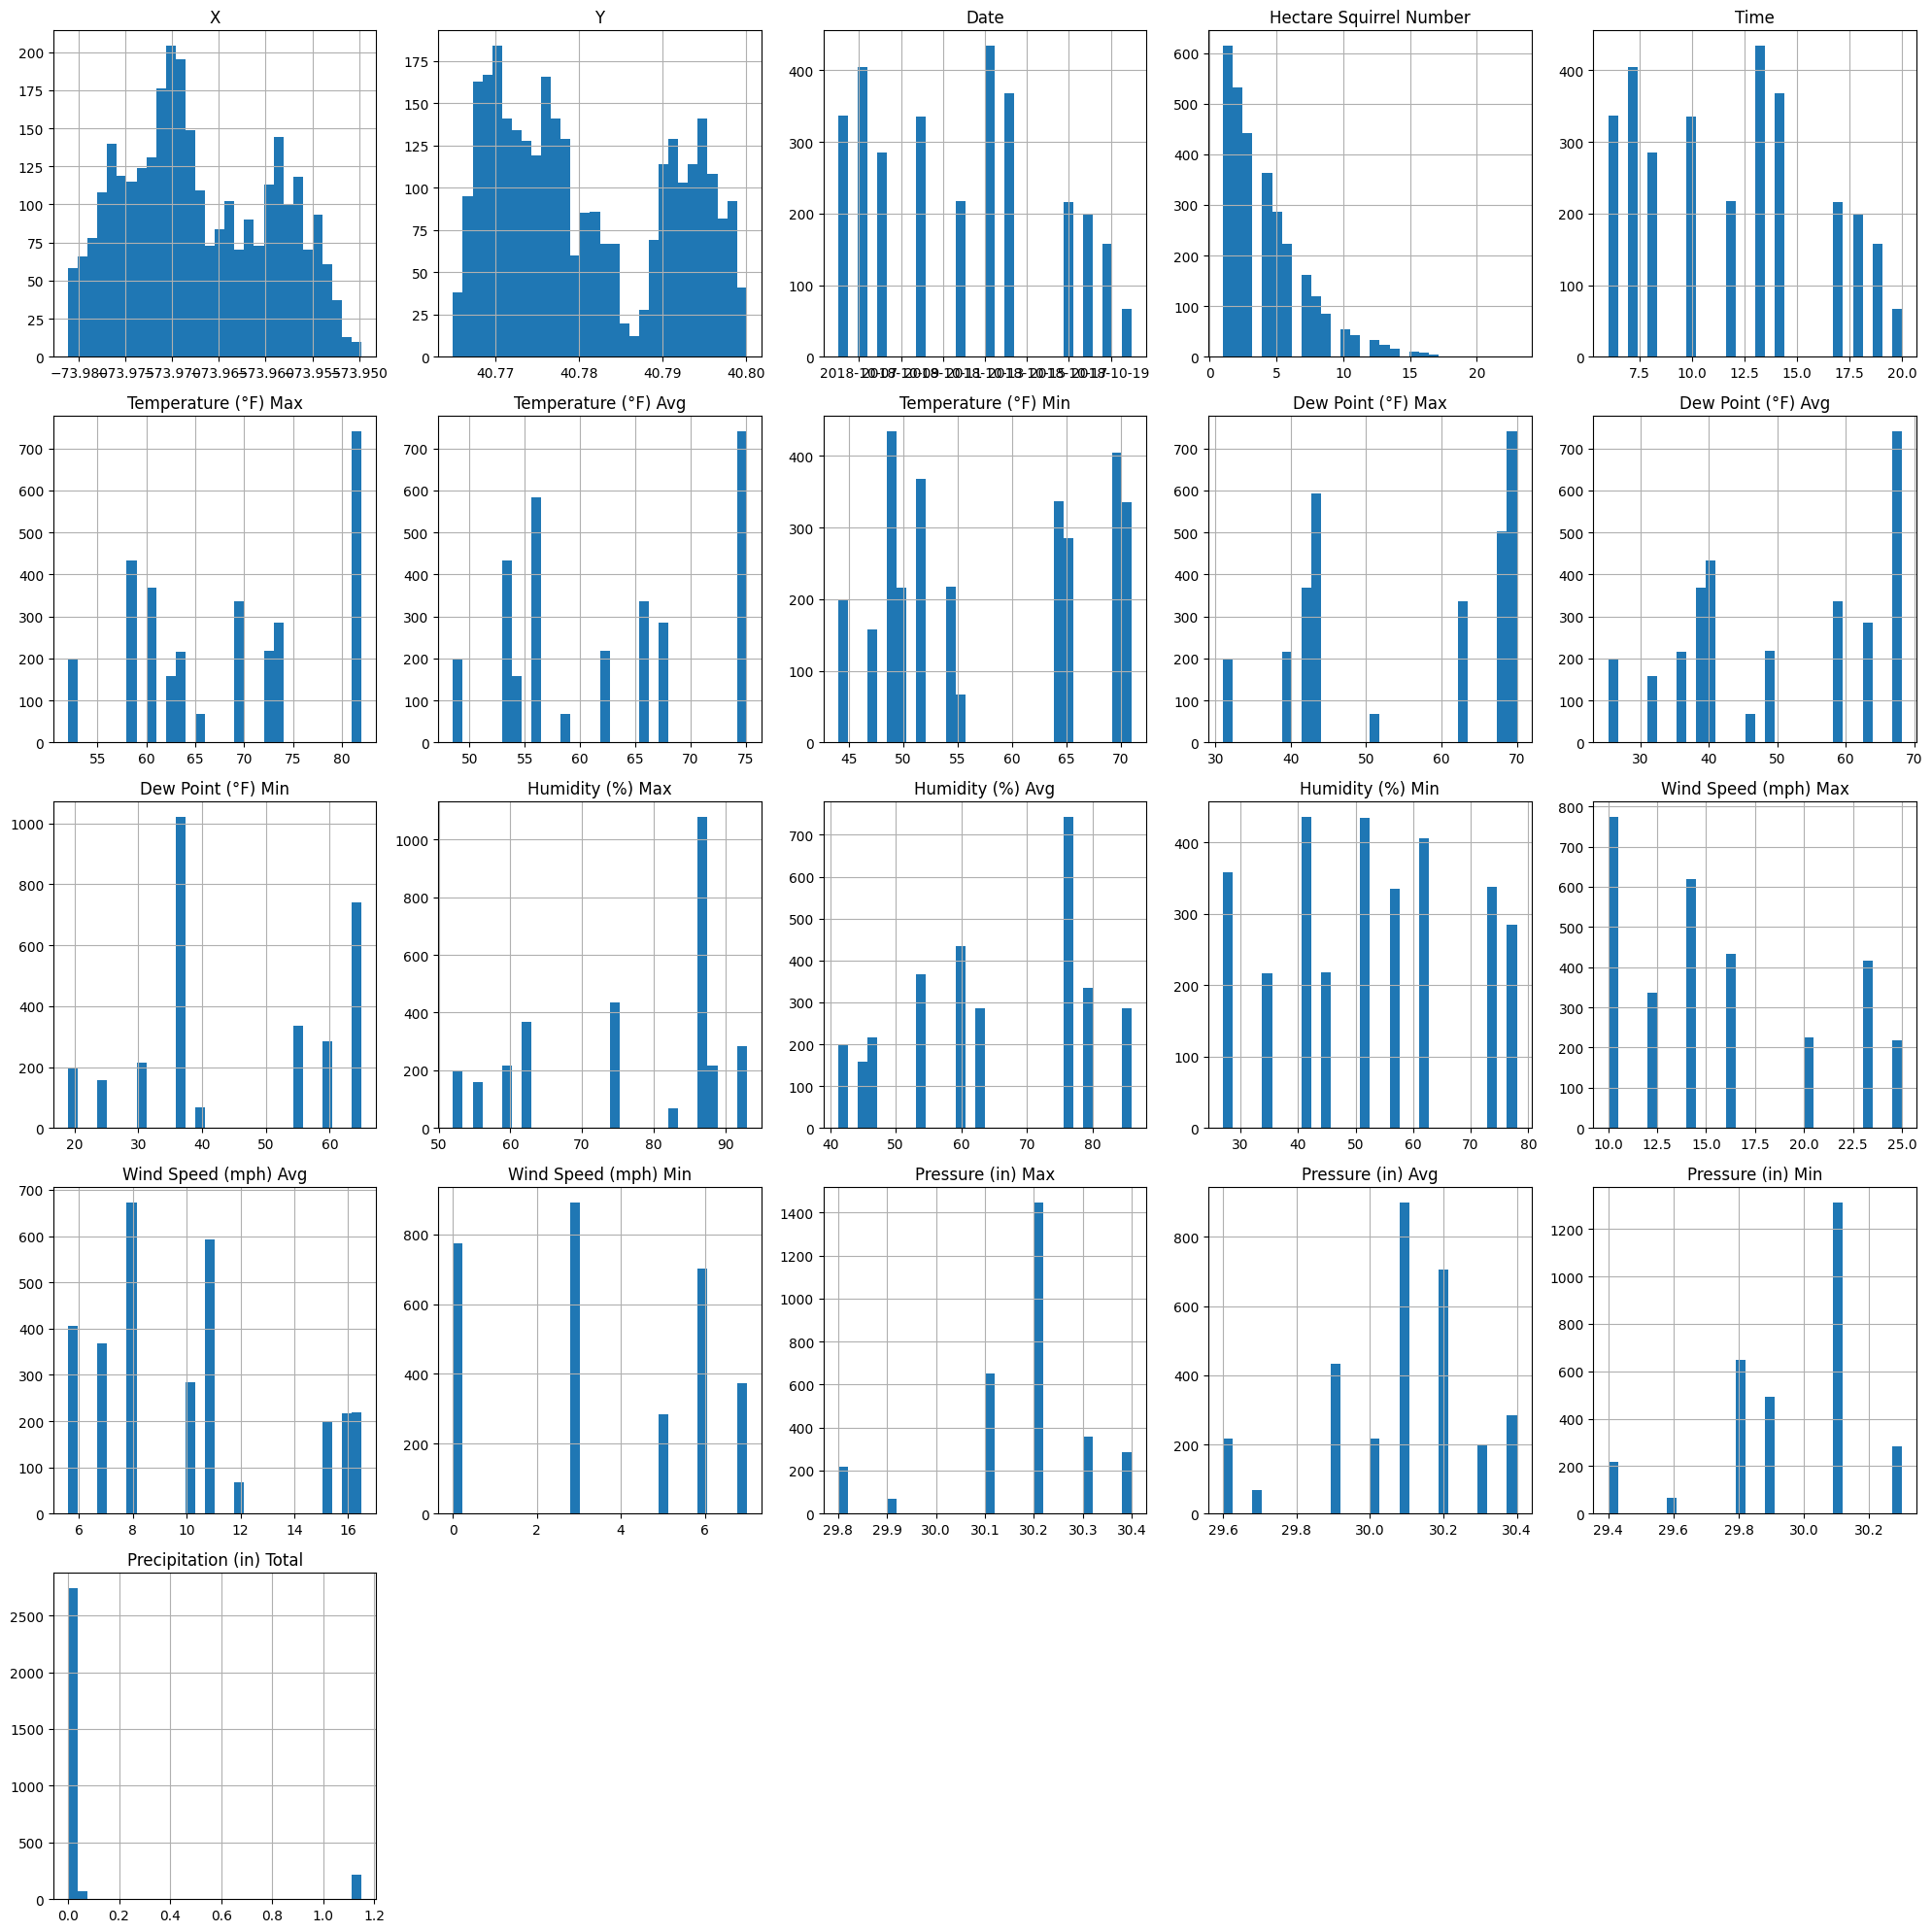

In [8]:
data.hist(figsize=(20, 20), bins=30)
plt.tight_layout()
plt.show()

In [9]:
# Extract boolean columns
boolean_columns = data.select_dtypes(include='bool').columns

# Calculate the proportion of True and False values for each boolean feature
boolean_summary = data[boolean_columns].apply(lambda x: x.value_counts(normalize=True)).T
boolean_summary.columns = ['False', 'True']

print(boolean_summary)

                  False      True
Running        0.758518  0.241482
Chasing        0.907708  0.092292
Climbing       0.782335  0.217665
Eating         0.748594  0.251406
Foraging       0.525306  0.474694
Kuks           0.966259  0.033741
Quaas          0.983460  0.016540
Moans          0.999008  0.000992
Tail flags     0.948726  0.051274
Tail twitches  0.856434  0.143566
Approaches     0.941118  0.058882
Indifferent    0.519021  0.480979
Runs from      0.775719  0.224281
Diseased       0.893483  0.106517


### Behavioral Feature Stratification Analysis

**Heavily Imbalanced Features**:
   - Features like `Kuks`, `Quaas`, `Moans`, and `Tail flags` are highly imbalanced, with few True values.
   - **Stratifying these features** may enhance model performance by ensuring adequate representation of both states, especially if these behaviors relate to sickness.

**Moderately Imbalanced Features**:
   - `Climbing`, `Eating`, `Tail twitches`, and `Runs from` show moderate imbalance. Consider stratifying these if they correlate with the target, though it's less critical than for heavily imbalanced features.

**Balanced Features**:
   - `Foraging` and `Indifferent` are well-balanced between True and False, so stratification is likely unnecessary.

**Target Label - Diseased**:
   - `Diseased` is moderately imbalanced, with True cases around 10.6%. **Stratifying this label is crucial** to maintain a balanced representation of both classes in each training split.


In [10]:
from scipy.stats import chi2_contingency

# Extract object columns
object_columns = data.select_dtypes(include='object').columns

# Function to perform chi-square test
def chi_square_test(data, object_columns, target):
    chi2_results = {}
    for col in object_columns:
        contingency_table = pd.crosstab(data[col], data[target])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        chi2_results[col] = {'chi2': chi2, 'p-value': p}
    return chi2_results

# Perform chi-square test
chi2_results = chi_square_test(data, object_columns, 'Diseased')

# Display the results
for col, result in chi2_results.items():
    print(f"Feature: {col}, Chi2: {result['chi2']}, p-value: {result['p-value']}")

Feature: Unique Squirrel ID, Chi2: 3022.9999999999995, p-value: 0.46582421236577864
Feature: Hectare, Chi2: 558.1316815698673, p-value: 4.720787340891054e-13
Feature: Shift, Chi2: 6.808624322270109e-06, p-value: 0.9979180549889929
Feature: Age, Chi2: 10.435804722551559, p-value: 0.00541868365409623
Feature: Primary Fur Color, Chi2: 1138.5172788862726, p-value: 5.944483338009056e-248
Feature: Highlight Fur Color, Chi2: 377.6592765783757, p-value: 7.961829841523003e-76
Feature: Combination of Primary and Highlight Color, Chi2: 1177.8680894100214, p-value: 3.1444250918913405e-236
Feature: Color notes, Chi2: 165.0708349926988, p-value: 0.03527359127715566
Feature: Location, Chi2: 2.728708899814244, p-value: 0.09855893167687874
Feature: Above Ground Sighter Measurement, Chi2: 32.00645671853988, p-value: 0.8120227997348299
Feature: Specific Location, Chi2: 364.7998397435897, p-value: 0.008557371025364233
Feature: Other Activities, Chi2: 327.1990784252297, p-value: 0.19360259984991715
Feature

### Chi-square Test Analysis for Feature Relevance to Target (Diseased)

This analysis assesses the association between each categorical feature and the target variable (`Diseased`) using the Chi-square test of independence. The Chi-square statistic (`chi2`) and p-value are reported for each feature, helping to identify features that may have predictive value.

#### Key Findings

1. **Significant Features (p-value < 0.05)**
   - **Hectare** (Chi2: 558.13, p-value: 4.72e-13): Indicates a strong association with `Diseased`, suggesting that squirrel density by park section could be relevant for predicting sickness.
   - **Primary Fur Color** (Chi2: 1138.52, p-value: 5.94e-248) and **Highlight Fur Color** (Chi2: 377.66, p-value: 7.96e-76): These fur color features have significant associations with the target, implying that certain fur colors may be indicators of sickness.
   - **Combination of Primary and Highlight Color** (Chi2: 1177.87, p-value: 3.14e-236): This combination is also strongly associated with `Diseased`, reinforcing the relevance of color attributes in the model.
   - **Color Notes** (Chi2: 165.07, p-value: 0.035): Although less strongly, this feature shows a significant association, indicating some potential relevance.
   - **Age** (Chi2: 10.44, p-value: 0.005): Suggests that age group may be relevant, with differences in sickness incidence between juveniles and adults.

   These features should be prioritized in the model and considered for stratification to ensure diverse representation across significant categories.

2. **Non-significant Features (p-value > 0.05)**
   - **Unique Squirrel ID** (p-value: 0.47) and **Shift (AM/PM)** (p-value: 0.99): These features show no significant association with `Diseased`, suggesting minimal predictive value.
   - **Lat/Long** (p-value: 0.49), **Location** (p-value: 0.10), and **Other Interactions** (p-value: 0.22): These features also lack statistical significance, indicating they may not contribute meaningful insights into the target label.

### Results

Based on the Chi-square test results:
   - **Include** significant features like `Hectare`, `Primary Fur Color`, `Highlight Fur Color`, and `Combination of Primary and Highlight Color`, as they show strong associations with the target and may enhance model accuracy.
   - **Exclude** non-significant features such as `Unique Squirrel ID`, `Shift`, and `Lat/Long`, as they are unlikely to impact the target variable.



In [11]:
# Function to calculate the proportion of each category in object columns
def calculate_proportions(data, object_columns):
    proportions = {}
    for col in object_columns:
        proportions[col] = data[col].value_counts(normalize=True)
    return proportions

# Calculate proportions for object columns
object_proportions = calculate_proportions(data, object_columns)

# Display the proportions
for col, prop in object_proportions.items():
    print(f"Proportions for {col}:\n{prop}\n")

# Determine if stratification is needed based on the proportions
stratify_columns = [col for col, prop in object_proportions.items() if prop.max() > 0.75]
print(f"Columns to stratify: {stratify_columns}")

Proportions for Unique Squirrel ID:
Unique Squirrel ID
7D-PM-1010-01     0.000662
40B-AM-1019-06    0.000662
37E-PM-1006-03    0.000662
4C-PM-1010-05     0.000662
1F-AM-1010-04     0.000662
                    ...   
13F-AM-1007-01    0.000331
12D-AM-1013-02    0.000331
2F-AM-1006-03     0.000331
9H-PM-1018-04     0.000331
5E-PM-1012-01     0.000331
Name: proportion, Length: 3018, dtype: float64

Proportions for Hectare:
Hectare
14D    0.010586
32E    0.009924
14E    0.009262
01B    0.008932
07H    0.008601
         ...   
11C    0.000331
23D    0.000331
26B    0.000331
24B    0.000331
30F    0.000331
Name: proportion, Length: 339, dtype: float64

Proportions for Shift:
Shift
PM    0.554416
AM    0.445584
Name: proportion, dtype: float64

Proportions for Age:
Age
Adult       0.884907
Juvenile    0.113715
?           0.001378
Name: proportion, dtype: float64

Proportions for Primary Fur Color:
Primary Fur Color
Gray        0.833221
Cinnamon    0.132075
Black       0.034704
Name: proport

### Stratification Analysis for Object Squirrel Dataset

This analysis identifies key features that may benefit from stratification to improve model performance and ensure balanced representation across groups. Stratification decisions are based on Chi-square test significance, feature distribution, and domain relevance.

#### Features Recommended for Stratification

1. **Hectare**:
   - **Reason**: Significant association with `Diseased` and noticeable imbalance in distribution across park sections. Stratifying by `Hectare` ensures diverse regional representation, capturing potential differences in disease prevalence by area.

2. **Shift (AM/PM)**:
   - **Reason**: Slight imbalance between AM and PM shifts. Although the Chi-square test did not show a strong association, time of day could impact squirrel behavior and sickness likelihood.
   - **Action**: Stratify to ensure both shifts are well-represented.

3. **Age**:
   - **Reason**: Significant association with `Diseased` and strong imbalance (mostly Adult). Age may impact disease susceptibility, so maintaining balanced age groups is important for generalization.
   - **Action**: Stratify by age to prevent bias toward adult squirrels.

4. **Primary Fur Color** and **Highlight Fur Color**:
   - **Reason**: Both fur color features have a significant association with `Diseased` and show imbalances (e.g., Gray is the predominant primary color). Fur color may be linked to disease risk.
   - **Action**: Stratify by color to ensure minority color groups are included.

5. **Combination of Primary and Highlight Color**:
   - **Reason**: Strong association with `Diseased` and varied distribution among color combinations, which may provide additional predictive power.
   - **Action**: Stratify by common combinations to enhance robustness across color patterns.

6. **Location**:
   - **Reason**: Imbalance between Ground Plane and Above Ground locations. Location could influence disease exposure or behavior.
   - **Action**: Stratify to ensure representation of both ground and above-ground sightings.

#### Features Excluded from Stratification

1. **Unique Squirrel ID** and **Lat/Long**:
   - **Reason**: No significant association with `Diseased` and primarily act as identifiers. These features do not contribute predictive value.
   - **Action**: Exclude from stratification.

2. **Specific Location**, **Other Activities**, **Other Interactions**, and **Color Notes**:
   - **Reason**: Limited association with `Diseased` and highly detailed categories, which may not meaningfully impact the target variable.
   - **Action**: Exclude from stratification unless further analysis suggests they are essential.

### Summary
The following features are recommended for stratification to enhance model performance and generalization: `Hectare`, `Shift`, `Age`, `Primary Fur Color`, `Highlight Fur Color`, `Combination of Primary and Highlight Color`, and `Location`. This approach ensures balanced representation across significant groups, supporting more accurate predictions of squirrel disease likelihood.


In [12]:
#show all columns
pd.set_option('display.max_columns', None)

data

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,Combination of Primary and Highlight Color,Color notes,Location,Above Ground Sighter Measurement,Specific Location,Running,Chasing,Climbing,Eating,Foraging,Other Activities,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long,Diseased,Time,Temperature (°F) Max,Temperature (°F) Avg,Temperature (°F) Min,Dew Point (°F) Max,Dew Point (°F) Avg,Dew Point (°F) Min,Humidity (%) Max,Humidity (%) Avg,Humidity (%) Min,Wind Speed (mph) Max,Wind Speed (mph) Avg,Wind Speed (mph) Min,Pressure (in) Max,Pressure (in) Avg,Pressure (in) Min,Precipitation (in) Total
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,+,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086),False,14,60,55.8,52,42,38.8,36,62,53.3,42,10,6.8,0,30.2,30.2,30.1,0.03
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,2018-10-19,4,NaN,NaN,NaN,+,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444),False,19,62,54.3,47,43,32.4,25,56,44.5,28,20,10.8,7,30.3,30.1,29.9,0.00
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,2018-10-14,8,NaN,Gray,NaN,Gray+,NaN,Above Ground,10,NaN,False,True,False,False,False,NaN,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083),False,14,60,55.8,52,42,38.8,36,62,53.3,42,10,6.8,0,30.2,30.2,30.1,0.03
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,2018-10-17,14,Adult,Gray,NaN,Gray+,Nothing selected as Primary. Gray selected as ...,NaN,NaN,NaN,False,False,False,True,True,NaN,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029),False,17,63,55.8,50,40,35.4,30,59,46.8,34,23,15.8,7,30.1,30.0,29.8,0.00
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,2018-10-17,5,Adult,Gray,Cinnamon,Gray+Cinnamon,NaN,Above Ground,NaN,on tree stump,False,False,False,False,True,NaN,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894),False,17,63,55.8,50,40,35.4,30,59,46.8,34,23,15.8,7,30.1,30.0,29.8,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,2018-10-07,4,Adult,Gray,NaN,Gray+,NaN,Ground Plane,FALSE,NaN,False,False,False,True,True,NaN,False,False,False,False,False,False,False,True,NaN,POINT (-73.9639431360458 40.7908677445466),False,7,81,74.7,70,69,66.8,64,87,77.0,62,10,5.6,0,30.2,30.1,30.1,0.00
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,2018-10-13,5,Adult,Gray,White,Gray+White,NaN,Ground Plane,FALSE,NaN,False,False,False,False,True,NaN,False,False,False,False,False,False,True,False,NaN,POINT (-73.9704015859639 40.7825600069973),False,13,58,53.3,49,43,39.7,36,74,60.6,51,16,10.9,6,30.1,29.9,29.8,0.02
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,2018-10-12,7,Adult,Gray,"Black, Cinnamon, White","Gray+Black, Cinnamon, White",NaN,Ground Plane,FALSE,NaN,False,False,False,True,True,NaN,False,False,False,False,False,False,True,False,NaN,POINT (-73.9665871993517 40.7836775064883),False,12,72,62.5,54,68,49.0,37,88,62.6,44,25,16.5,3,29.8,29.6,29.4,1.15
3021,-73.963994,40.789915,29B-PM-1010-02,29B,PM,2018-10-10,2,NaN,Gray,"Cinnamon, White","Gray+Cinnamon, White",NaN,Ground Plane,FALSE,NaN,False,False,False,True,False,NaN,False,False,False,False,False,False,True,False,NaN,POINT (-73.9639941227864 40.7899152327912),False,10,82,75.1,71,70,68.2,65,87,79.5,56,14,7.9,3,30.2,30.1,29.9,0.00


In [13]:
#train test split 
from sklearn.model_selection import train_test_split

X = data.drop('Diseased', axis=1)
y = data['Diseased']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


Didnt stratify moan because so little data it was impossible to stratify.

# Data Visualization

In [14]:
# create train set which has target and other columns
train = X_train.copy()
train['Diseased'] = y_train

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Hectare Squirrel Number'}>,
        <Axes: title={'center': 'Time'}>],
       [<Axes: title={'center': 'Temperature (°F) Max'}>,
        <Axes: title={'center': 'Temperature (°F) Avg'}>,
        <Axes: title={'center': 'Temperature (°F) Min'}>,
        <Axes: title={'center': 'Dew Point (°F) Max'}>,
        <Axes: title={'center': 'Dew Point (°F) Avg'}>],
       [<Axes: title={'center': 'Dew Point (°F) Min'}>,
        <Axes: title={'center': 'Humidity (%) Max'}>,
        <Axes: title={'center': 'Humidity (%) Avg'}>,
        <Axes: title={'center': 'Humidity (%) Min'}>,
        <Axes: title={'center': 'Wind Speed (mph) Max'}>],
       [<Axes: title={'center': 'Wind Speed (mph) Avg'}>,
        <Axes: title={'center': 'Wind Speed (mph) Min'}>,
        <Axes: title={'center': 'Pressure (in) Max'}>,
        <Axes: title={'center': 'Pressure (in) Av

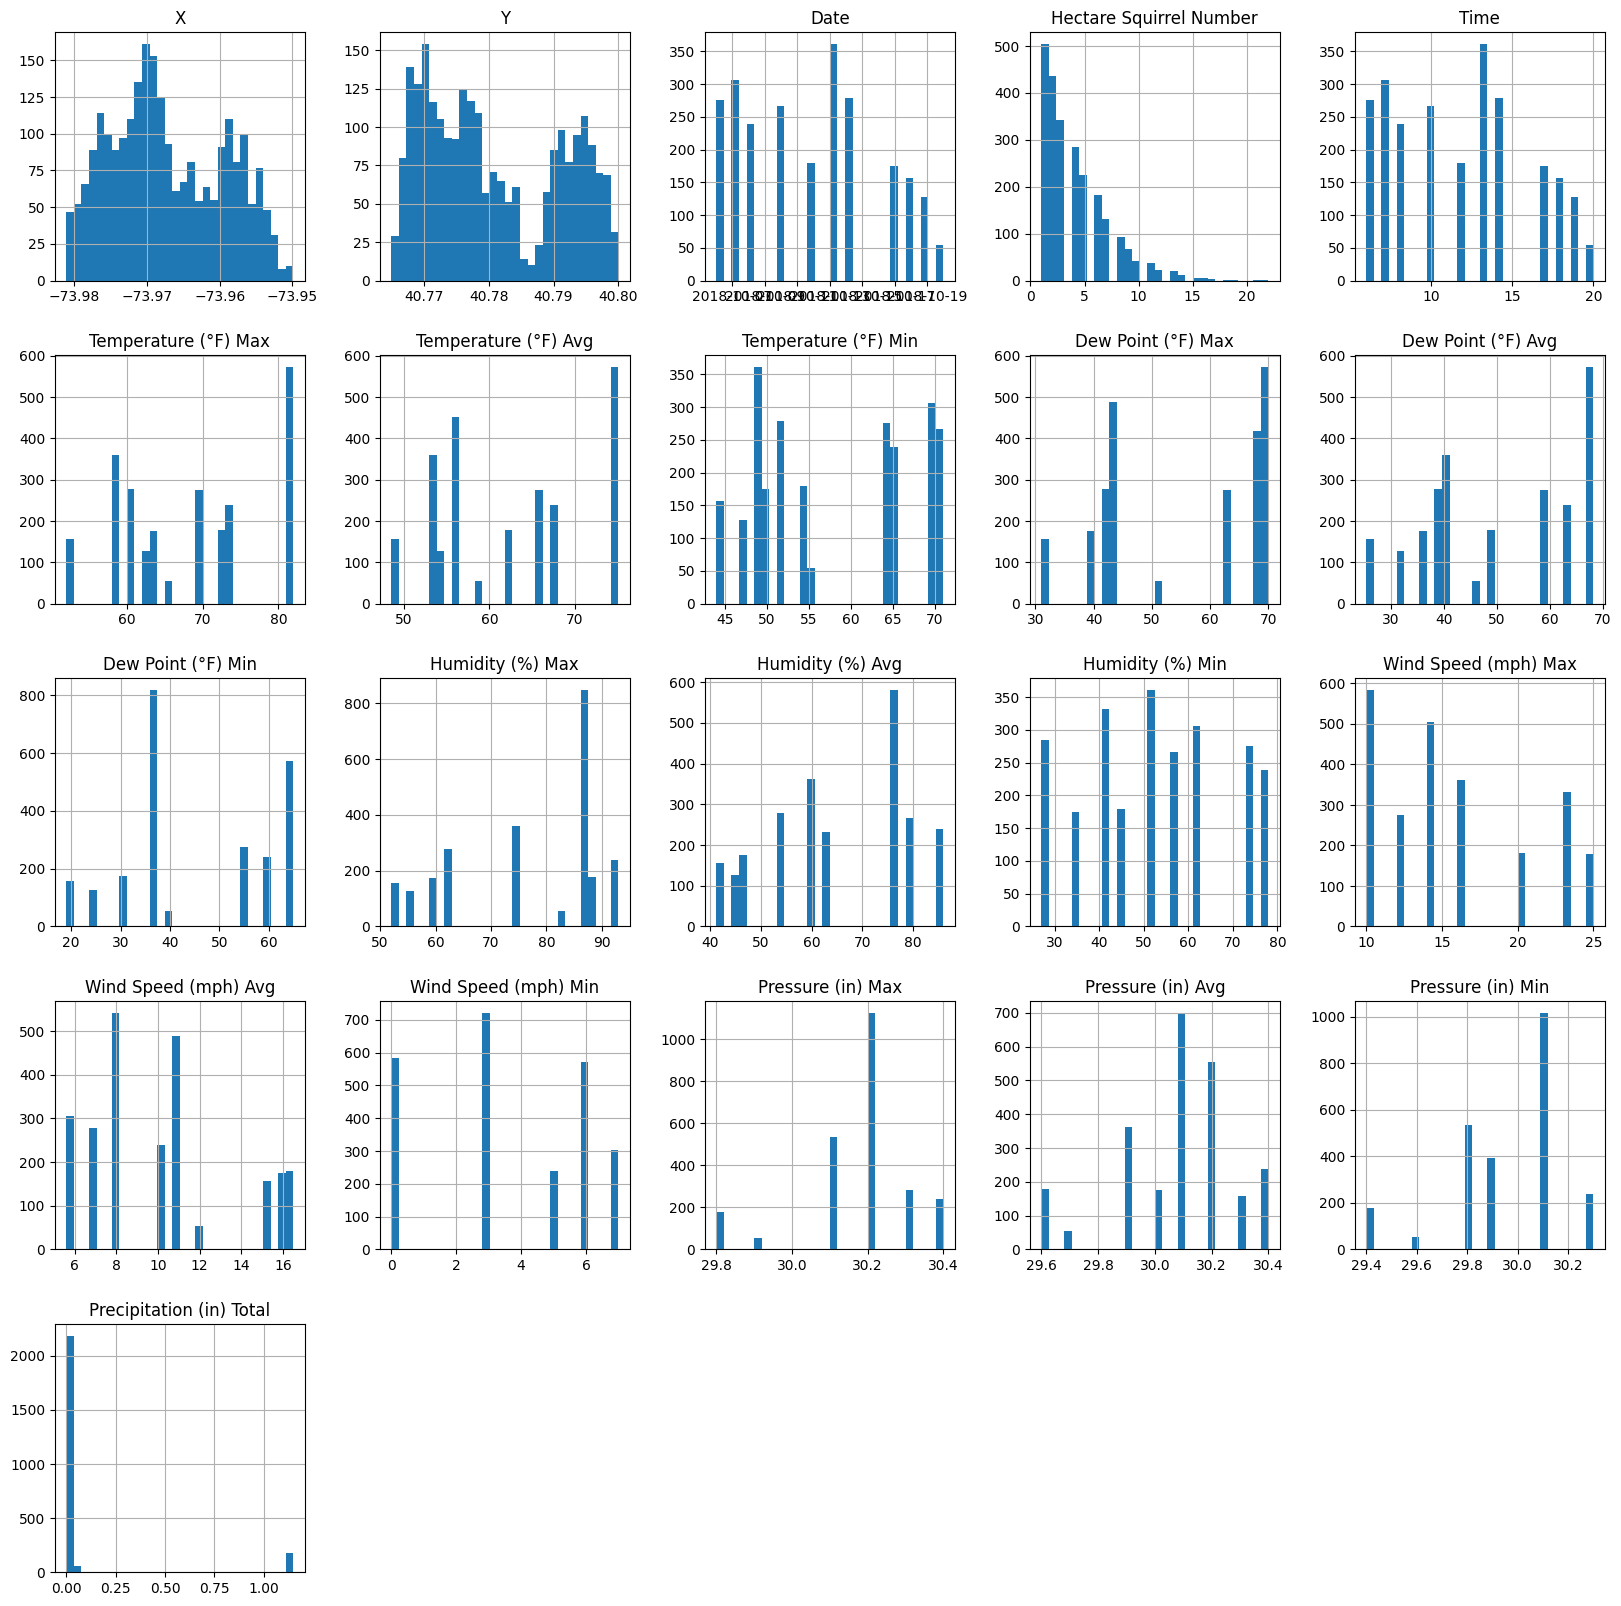

In [15]:
#histrogram of train set for numerical columns
train.hist(figsize=(20, 20), bins=30)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2418 entries, 1403 to 1006
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   X                                           2418 non-null   float64       
 1   Y                                           2418 non-null   float64       
 2   Unique Squirrel ID                          2418 non-null   object        
 3   Hectare                                     2418 non-null   object        
 4   Shift                                       2418 non-null   object        
 5   Date                                        2418 non-null   datetime64[ns]
 6   Hectare Squirrel Number                     2418 non-null   int64         
 7   Age                                         2330 non-null   object        
 8   Primary Fur Color                           2378 non-null   object        
 9   Highlight 

<Axes: xlabel='Unique Squirrel ID', ylabel='count'>

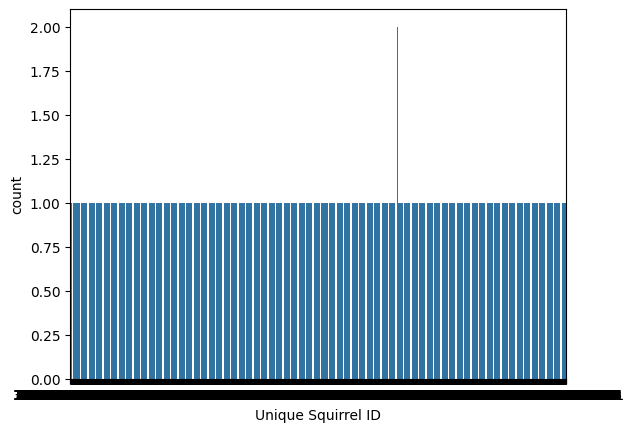

In [17]:
# plot Unique Squirrel ID

sns.countplot(data=train, x='Unique Squirrel ID')


<Axes: xlabel='Hectare', ylabel='count'>

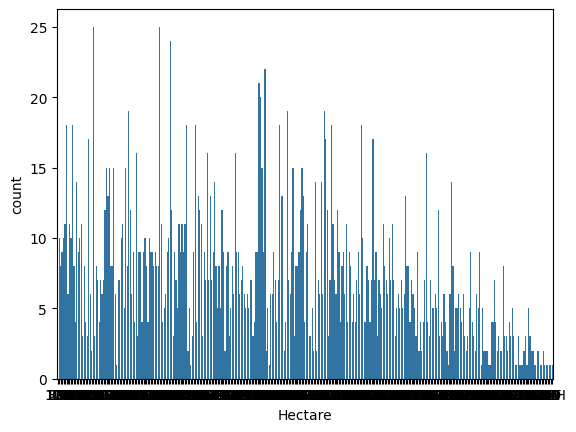

In [18]:
# plot Hectare

sns.countplot(data=train, x='Hectare')

<Axes: xlabel='Shift', ylabel='count'>

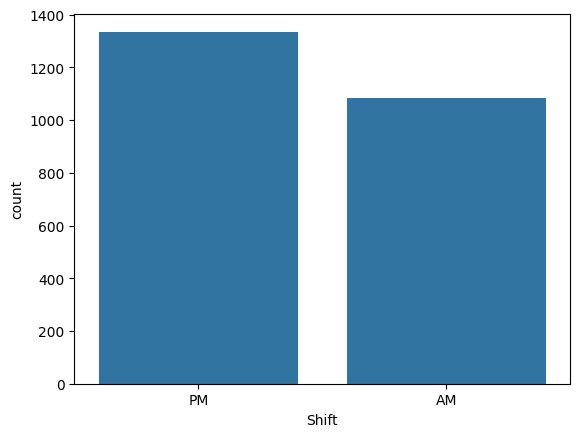

In [19]:
# plot Shift

sns.countplot(data=train, x='Shift')

<Axes: xlabel='Age', ylabel='count'>

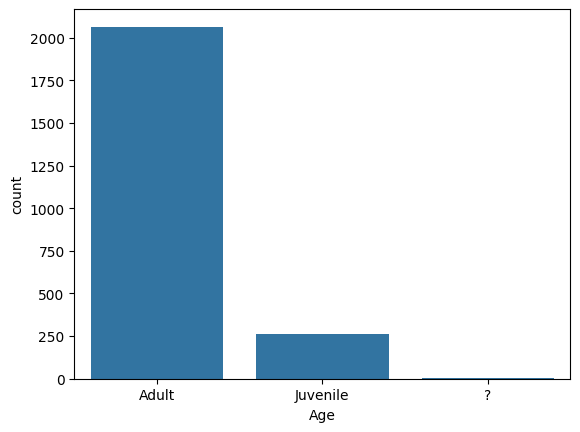

In [20]:
# plot Age

sns.countplot(data=train, x='Age')

<Axes: xlabel='Primary Fur Color', ylabel='count'>

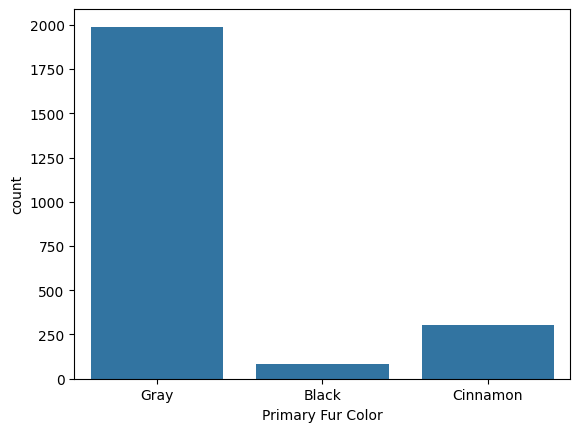

In [21]:
# plot Primary Fur Color

sns.countplot(data=train, x='Primary Fur Color')

<Axes: xlabel='Highlight Fur Color', ylabel='count'>

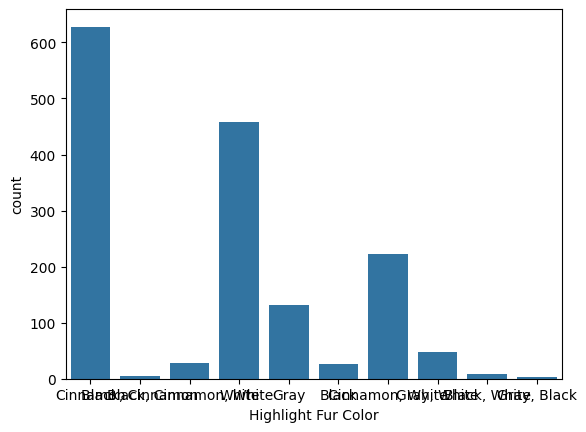

In [22]:
# plot Highlight Fur Color

sns.countplot(data=train, x='Highlight Fur Color')

<Axes: xlabel='Combination of Primary and Highlight Color', ylabel='count'>

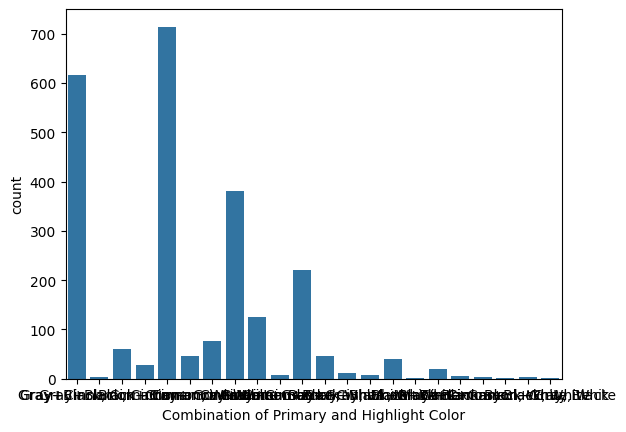

In [23]:
# plot Combination of Primary and Highlight Color

sns.countplot(data=train, x='Combination of Primary and Highlight Color')

<Axes: xlabel='Color notes', ylabel='count'>

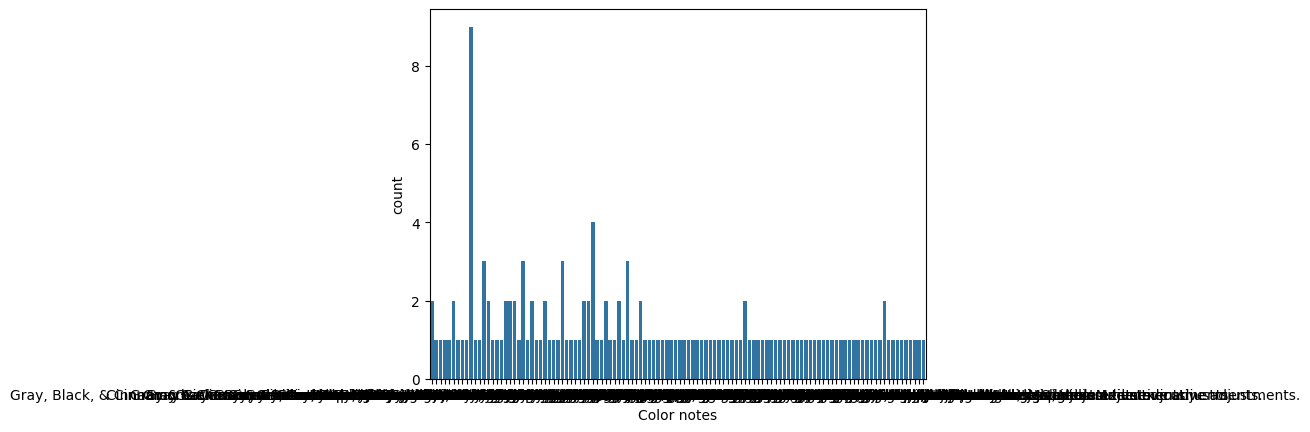

In [24]:
# plot Color notes

sns.countplot(data=train, x='Color notes')

<Axes: xlabel='Location', ylabel='count'>

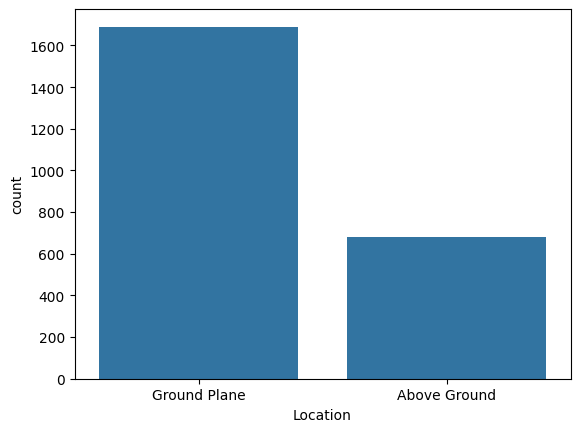

In [25]:
# plot Location

sns.countplot(data=train, x='Location')

<Axes: xlabel='Above Ground Sighter Measurement', ylabel='count'>

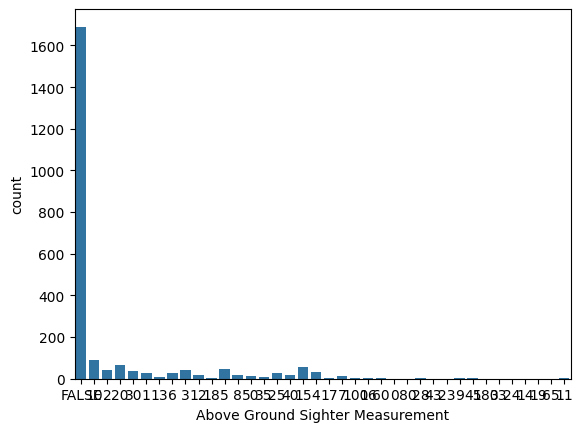

In [26]:
# plot Above Ground Sighter Measurement

sns.countplot(data=train, x='Above Ground Sighter Measurement')

<Axes: xlabel='Specific Location', ylabel='count'>

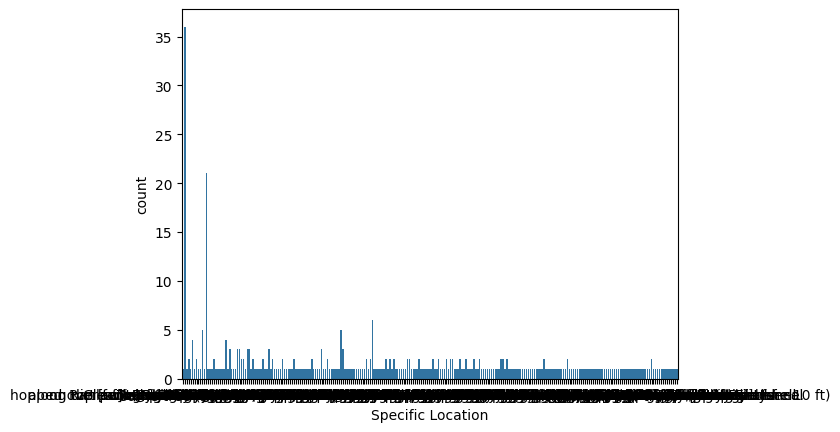

In [27]:
# plot Specific Location

sns.countplot(data=train, x='Specific Location')

In [28]:
 train['Specific Location'].value_counts()

Specific Location
tree          36
in tree       21
Tree           6
on fence       5
treed area     5
              ..
on hill        1
A rock         1
rocks          1
On a rock      1
up tree        1
Name: count, Length: 254, dtype: int64

<Axes: xlabel='Running', ylabel='count'>

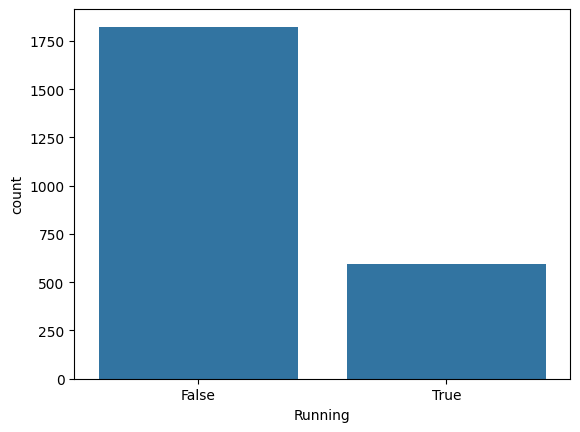

In [29]:
# plot Running

sns.countplot(data=train, x='Running')

<Axes: xlabel='Chasing', ylabel='count'>

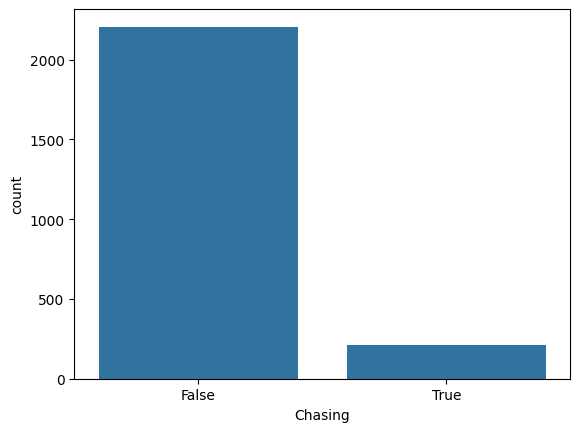

In [30]:
# plot Chasing

sns.countplot(data=train, x='Chasing')

<Axes: xlabel='Climbing', ylabel='count'>

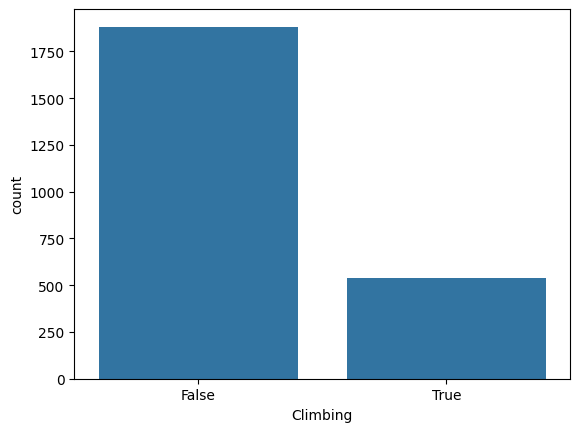

In [31]:
# plot Climbing

sns.countplot(data=train, x='Climbing')

<Axes: xlabel='Eating', ylabel='count'>

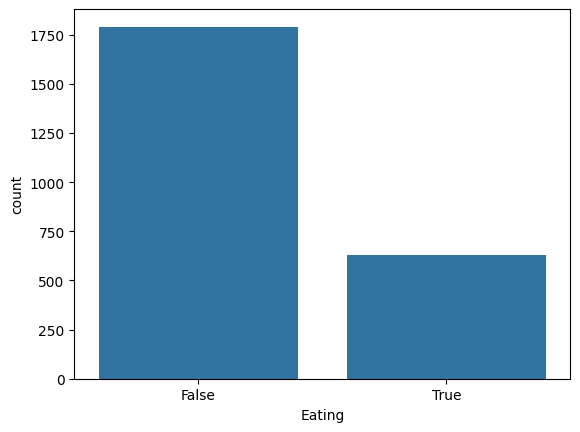

In [32]:
# plot Eating

sns.countplot(data=train, x='Eating')

<Axes: xlabel='Foraging', ylabel='count'>

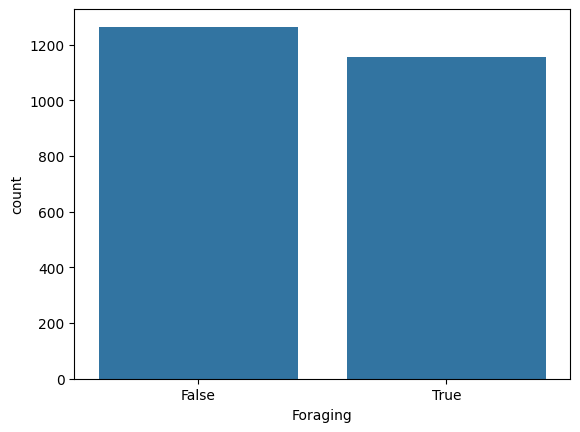

In [33]:
# plot Foraging

sns.countplot(data=train, x='Foraging')

<Axes: xlabel='Other Activities', ylabel='count'>

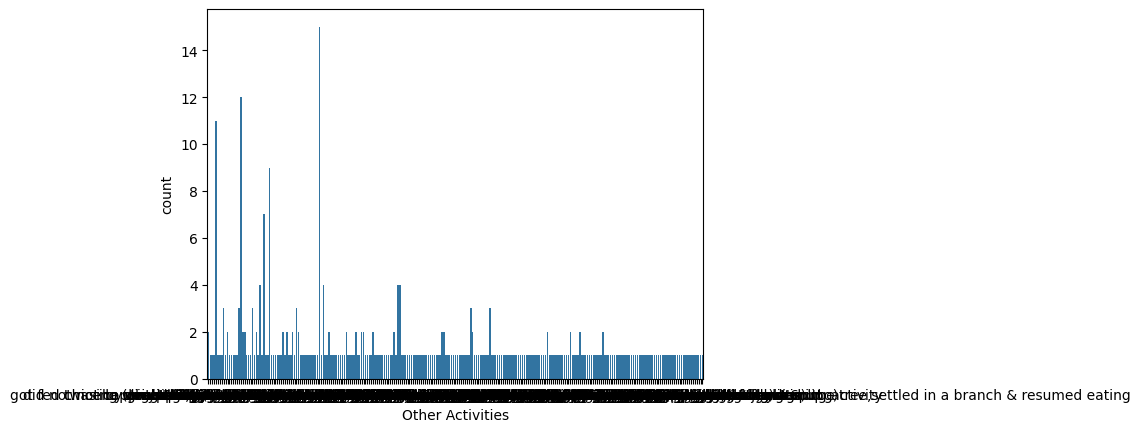

In [34]:
# plot Other Activities

sns.countplot(data=train, x='Other Activities')

<Axes: xlabel='Kuks', ylabel='count'>

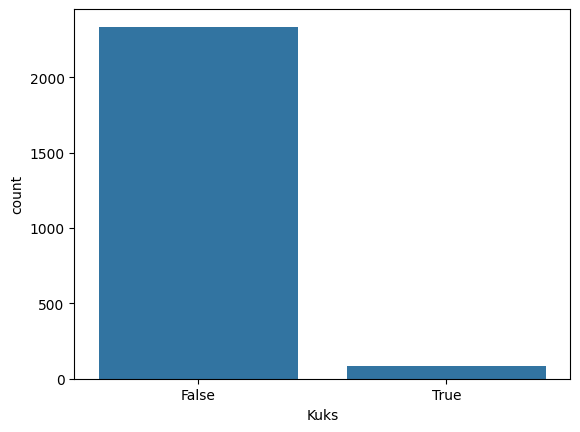

In [35]:
# plot Kuks

sns.countplot(data=train, x='Kuks')

<Axes: xlabel='Quaas', ylabel='count'>

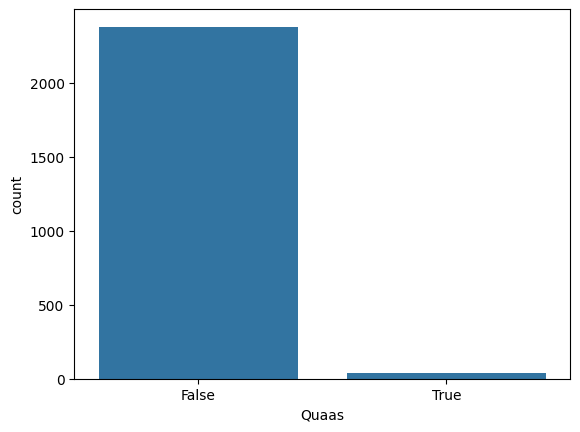

In [36]:
# plot Quaas

sns.countplot(data=train, x='Quaas')

<Axes: xlabel='Moans', ylabel='count'>

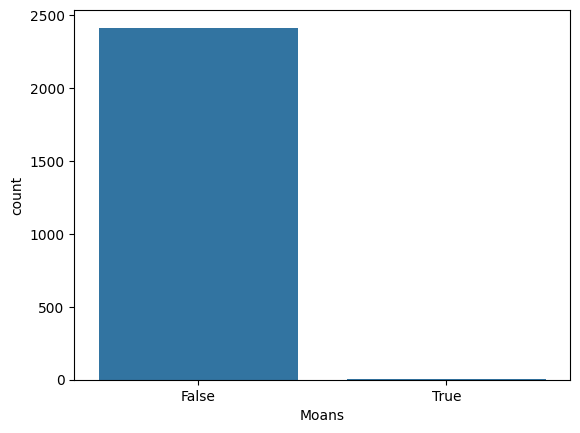

In [37]:
# plot Moans

sns.countplot(data=train, x='Moans')

<Axes: xlabel='Tail flags', ylabel='count'>

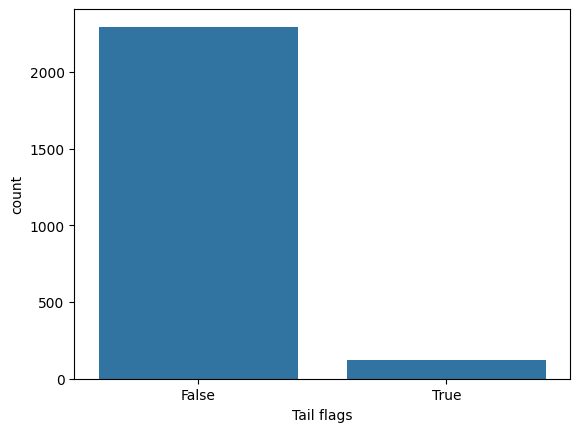

In [38]:
# plot Tail flags

sns.countplot(data=train, x='Tail flags')

<Axes: xlabel='Tail twitches', ylabel='count'>

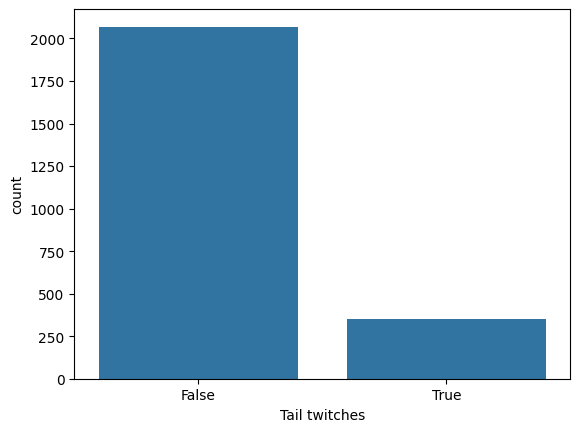

In [39]:
# plot Tail twitches

sns.countplot(data=train, x='Tail twitches')

<Axes: xlabel='Approaches', ylabel='count'>

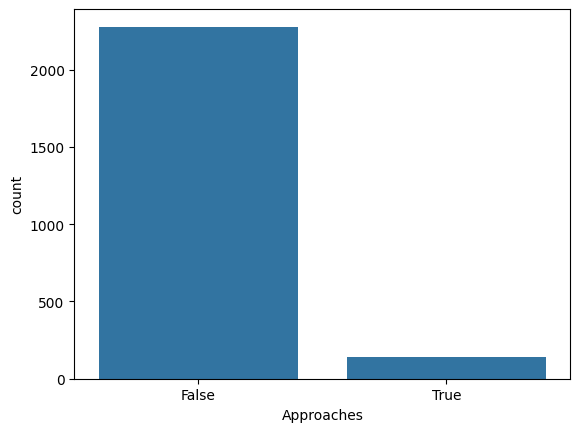

In [40]:
# plot Approaches

sns.countplot(data=train, x='Approaches')

<Axes: xlabel='Indifferent', ylabel='count'>

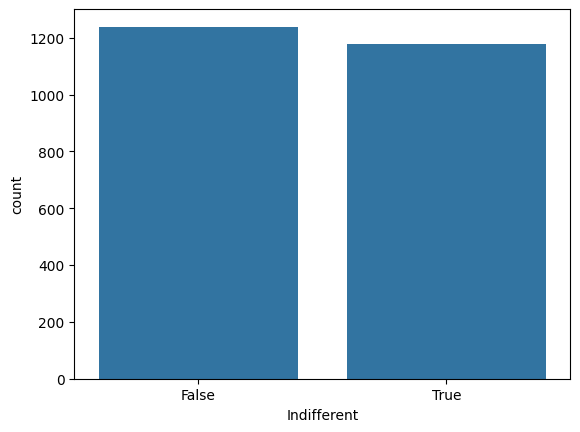

In [41]:
# plot Indifferent

sns.countplot(data=train, x='Indifferent')

<Axes: xlabel='Runs from', ylabel='count'>

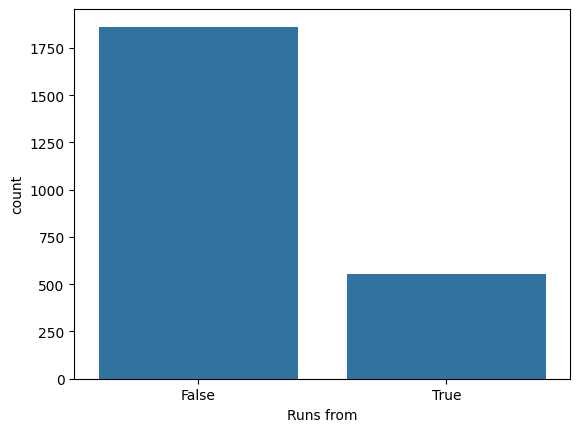

In [42]:
# plot Runs from 

sns.countplot(data=train, x='Runs from')

<Axes: xlabel='Other Interactions', ylabel='count'>

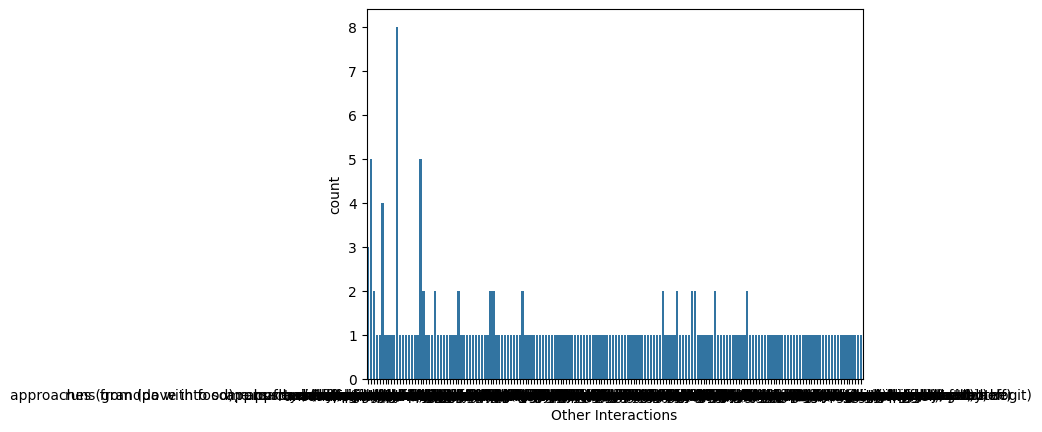

In [43]:
# plot Other Interactions

sns.countplot(data=train, x='Other Interactions')

<Axes: xlabel='Lat/Long', ylabel='count'>

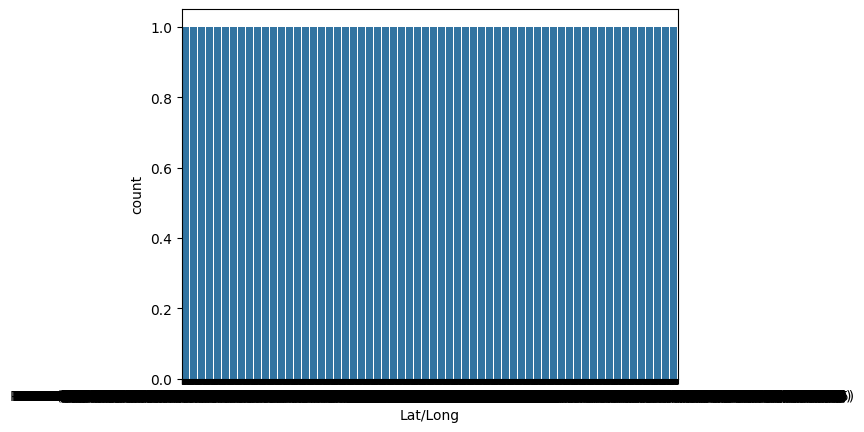

In [44]:
# plot Lat/Long

sns.countplot(data=train, x='Lat/Long')

<Axes: xlabel='Diseased', ylabel='count'>

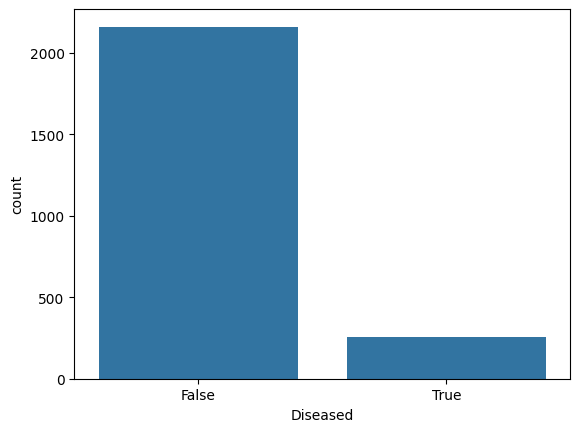

In [45]:
# plot Diseased

sns.countplot(data=train, x='Diseased')

In [46]:
# Convert all boolean columns to integers (0 and 1) for correlation checking
train = train.astype({col: 'int' for col in train.select_dtypes(include='bool').columns})

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2418 entries, 1403 to 1006
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   X                                           2418 non-null   float64       
 1   Y                                           2418 non-null   float64       
 2   Unique Squirrel ID                          2418 non-null   object        
 3   Hectare                                     2418 non-null   object        
 4   Shift                                       2418 non-null   object        
 5   Date                                        2418 non-null   datetime64[ns]
 6   Hectare Squirrel Number                     2418 non-null   int64         
 7   Age                                         2330 non-null   object        
 8   Primary Fur Color                           2378 non-null   object        
 9   Highlight 

In [48]:
train['Age'].value_counts()

Age
Adult       2064
Juvenile     264
?              2
Name: count, dtype: int64

In [49]:
# make new Column for Age called Age_Adult and make it 1 for being Adult and 0 for not being adult

train['Age_Adult'] = train['Age'].apply(lambda x: 1 if x == 'Adult' else 0)

train['Age_Adult'].value_counts()

Age_Adult
1    2064
0     354
Name: count, dtype: int64

In [50]:
# make new Column for Age called Age_Juvenile and make it 1 for being Juvenile and 0 for not being Juvenile

train['Age_Juvenile'] = train['Age'].apply(lambda x: 1 if x == 'Juvenile' else 0)

train['Age_Juvenile'].value_counts()

Age_Juvenile
0    2154
1     264
Name: count, dtype: int64

In [51]:
# make new Column for Age called Age_Unknown and make it 1 for being Unknown and 0 for not being Unknown

train['Age_Unknown'] = train['Age'].apply(lambda x: 1 if x == '?' else 0)

train['Age_Unknown'].value_counts()

Age_Unknown
0    2416
1       2
Name: count, dtype: int64

In [52]:
train['Shift'].value_counts()

Shift
PM    1335
AM    1083
Name: count, dtype: int64

In [53]:
# create new shift column Shift_Binary and make it 1 for being PM and 0 for being AM

train['Shift_Binary'] = train['Shift'].apply(lambda x: 1 if x == 'PM' else 0)

train['Shift_Binary'].value_counts()


Shift_Binary
1    1335
0    1083
Name: count, dtype: int64

In [54]:
train['Primary Fur Color'].value_counts()

Primary Fur Color
Gray        1989
Cinnamon     306
Black         83
Name: count, dtype: int64

In [55]:
# create new column for Primary Fur Color Gray

train['Primary Fur Color_Gray'] = train['Primary Fur Color'].apply(lambda x: 1 if x == 'Gray' else 0)

Gray= train['Primary Fur Color_Gray'].value_counts()

# create new column for Primary Fur Color Cinnamon

train['Primary Fur Color_Cinnamon'] = train['Primary Fur Color'].apply(lambda x: 1 if x == 'Cinnamon' else 0)

Cinnamon = train['Primary Fur Color_Cinnamon'].value_counts()

# create new column for Primary Fur Color Black

train['Primary Fur Color_Black'] = train['Primary Fur Color'].apply(lambda x: 1 if x == 'Black' else 0)

Black = train['Primary Fur Color_Black'].value_counts()

Gray, Cinnamon, Black

(Primary Fur Color_Gray
 1    1989
 0     429
 Name: count, dtype: int64,
 Primary Fur Color_Cinnamon
 0    2112
 1     306
 Name: count, dtype: int64,
 Primary Fur Color_Black
 0    2335
 1      83
 Name: count, dtype: int64)

In [56]:
train['Highlight Fur Color'].value_counts()

Highlight Fur Color
Cinnamon                  628
White                     458
Cinnamon, White           223
Gray                      131
Gray, White                47
Black, Cinnamon, White     28
Black                      26
Black, White                8
Black, Cinnamon             4
Gray, Black                 3
Name: count, dtype: int64

In [57]:
# break up highlight fur color into new columns Black, White, Gray, Cinnamon. If the color is present, the value is 1

#in case there is NA values, fill them with empty string for separation
train['Highlight Fur Color'] = train['Highlight Fur Color'].fillna('').astype(str)

train['Highlight Fur Color_Black'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'Black' in x else 0)

train['Highlight Fur Color_White'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'White' in x else 0)

train['Highlight Fur Color_Gray'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'Gray' in x else 0)

train['Highlight Fur Color_Cinnamon'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'Cinnamon' in x else 0)

train['Highlight Fur Color_Black'].value_counts(), train['Highlight Fur Color_White'].value_counts(), train['Highlight Fur Color_Gray'].value_counts(), train['Highlight Fur Color_Cinnamon'].value_counts()

(Highlight Fur Color_Black
 0    2349
 1      69
 Name: count, dtype: int64,
 Highlight Fur Color_White
 0    1654
 1     764
 Name: count, dtype: int64,
 Highlight Fur Color_Gray
 0    2237
 1     181
 Name: count, dtype: int64,
 Highlight Fur Color_Cinnamon
 0    1535
 1     883
 Name: count, dtype: int64)

In [58]:
train['Color notes'].value_counts()

Color notes
Gray & Cinnamon selected as Primary. White selected as Highlights. Made executive adjustments.                     9
white belly                                                                                                        4
white back legs                                                                                                    3
Listed as primary white with cinnamon highlights, I changed to Gray/cinnamon - JO                                  3
White tail                                                                                                         3
                                                                                                                  ..
Can't tell :(                                                                                                      1
Gray & Cinnamon selected as Primary: "much browner, like 1/2 & 1/2".                                               1
Gray & Cinnamon selected as Primary. Gray, Cinnamon 

In [59]:
train['Combination of Primary and Highlight Color'].value_counts()

Combination of Primary and Highlight Color
Gray+                          714
Gray+Cinnamon                  617
Gray+White                     380
Gray+Cinnamon, White           220
Cinnamon+Gray                  126
Cinnamon+White                  76
Black+                          61
Cinnamon+                       47
Cinnamon+Gray, White            46
+                               40
Gray+Black, Cinnamon, White     28
Gray+Black                      19
Black+Cinnamon                  11
Cinnamon+Black                   7
Gray+Black, White                7
Black+Gray                       5
Gray+Black, Cinnamon             4
Black+Cinnamon, White            3
Cinnamon+Gray, Black             3
Black+White                      2
Cinnamon+Black, White            1
Black+Gray, White                1
Name: count, dtype: int64

In [60]:
train['Location'].value_counts()

# create new column for Location Ground Plane and Above Ground. 1 is for being Above Ground and 0 for being Ground Plane

train['Location_Binary'] = train['Location'].apply(lambda x: 1 if x == 'Ground Plane' else 0)

train['Location_Binary'].value_counts()

Location_Binary
1    1690
0     728
Name: count, dtype: int64

In [61]:
train['Above Ground Sighter Measurement'].value_counts()

Above Ground Sighter Measurement
FALSE    1690
10         88
20         67
15         58
5          48
2          42
3          42
30         36
4          33
6          28
25         26
1          26
40         20
8          19
12         16
7          15
50         14
35          9
13          9
28          5
18          5
100         4
45          4
9           4
17          3
60          2
16          2
11          2
80          1
0           1
43          1
23          1
180         1
33          1
24          1
14          1
19          1
65          1
Name: count, dtype: int64

In [62]:
train['Specific Location'].value_counts()

Specific Location
tree          36
in tree       21
Tree           6
on fence       5
treed area     5
              ..
on hill        1
A rock         1
rocks          1
On a rock      1
up tree        1
Name: count, Length: 254, dtype: int64

In [63]:
train['Hectare'].value_counts()

Hectare
14E    25
14D    25
32E    24
01B    22
13D    21
       ..
24B     1
41G     1
18E     1
23D     1
40H     1
Name: count, Length: 335, dtype: int64

In [64]:
train

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,Combination of Primary and Highlight Color,Color notes,Location,Above Ground Sighter Measurement,Specific Location,Running,Chasing,Climbing,Eating,Foraging,Other Activities,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long,Time,Temperature (°F) Max,Temperature (°F) Avg,Temperature (°F) Min,Dew Point (°F) Max,Dew Point (°F) Avg,Dew Point (°F) Min,Humidity (%) Max,Humidity (%) Avg,Humidity (%) Min,Wind Speed (mph) Max,Wind Speed (mph) Avg,Wind Speed (mph) Min,Pressure (in) Max,Pressure (in) Avg,Pressure (in) Min,Precipitation (in) Total,Diseased,Age_Adult,Age_Juvenile,Age_Unknown,Shift_Binary,Primary Fur Color_Gray,Primary Fur Color_Cinnamon,Primary Fur Color_Black,Highlight Fur Color_Black,Highlight Fur Color_White,Highlight Fur Color_Gray,Highlight Fur Color_Cinnamon,Location_Binary
1403,-73.970067,40.774286,12F-PM-1007-08,12F,PM,2018-10-07,8,Adult,Gray,Cinnamon,Gray+Cinnamon,NaN,Ground Plane,FALSE,NaN,0,0,0,1,1,NaN,0,0,0,0,0,0,0,0,stared,POINT (-73.9700666654946 40.7742857042581),7,81,74.7,70,69,66.8,64,87,77.0,62,10,5.6,0,30.2,30.1,30.1,0.00,0,1,0,0,1,1,0,0,0,0,0,1,1
2648,-73.970643,40.776293,13E-AM-1017-07,13E,AM,2018-10-17,7,Adult,Gray,Cinnamon,Gray+Cinnamon,NaN,Ground Plane,FALSE,NaN,0,0,0,0,1,NaN,0,0,0,0,0,0,1,0,NaN,POINT (-73.9706428641753 40.7762933936464),17,63,55.8,50,40,35.4,30,59,46.8,34,23,15.8,7,30.1,30.0,29.8,0.00,0,1,0,0,0,1,0,0,0,0,0,1,1
1374,-73.956474,40.793885,36F-AM-1017-03,36F,AM,2018-10-17,3,Adult,Gray,Cinnamon,Gray+Cinnamon,Cinnamon on shoulders,Ground Plane,FALSE,NaN,0,0,0,1,1,NaN,0,0,0,0,0,0,0,1,runs from (me),POINT (-73.9564741038174 40.7938845572816),17,63,55.8,50,40,35.4,30,59,46.8,34,23,15.8,7,30.1,30.0,29.8,0.00,0,1,0,0,0,1,0,0,0,0,0,1,1
548,-73.964383,40.781545,21F-PM-1018-03,21F,PM,2018-10-18,3,Adult,Gray,Cinnamon,Gray+Cinnamon,NaN,Ground Plane,FALSE,NaN,0,0,0,0,1,NaN,0,0,0,0,0,0,0,0,NaN,POINT (-73.9643825381614 40.7815445841195),18,52,48.5,44,31,25.3,19,52,41.2,27,23,15.2,6,30.3,30.3,30.1,0.00,0,1,0,0,1,1,0,0,0,0,0,1,1
1897,-73.971074,40.772327,10F-PM-1019-07,10F,PM,2018-10-19,7,Adult,Gray,Cinnamon,Gray+Cinnamon,NaN,Above Ground,10,Same tree (as #6),0,0,1,0,0,NaN,0,0,0,0,0,0,1,0,NaN,POINT (-73.97107389601 40.7723265810536),19,62,54.3,47,43,32.4,25,56,44.5,28,20,10.8,7,30.3,30.1,29.9,0.00,0,1,0,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,-73.968664,40.784318,22B-PM-1014-01,22B,PM,2018-10-14,1,Juvenile,Gray,Cinnamon,Gray+Cinnamon,NaN,Ground Plane,FALSE,NaN,0,0,0,0,1,NaN,0,0,0,0,0,0,0,0,NaN,POINT (-73.96866350179661 40.7843176732828),14,60,55.8,52,42,38.8,36,62,53.3,42,10,6.8,0,30.2,30.2,30.1,0.03,0,0,1,0,1,1,0,0,0,0,0,1,1
493,-73.954843,40.798207,41E-AM-1007-06,41E,AM,2018-10-07,6,Adult,Gray,,Gray+,NaN,Above Ground,30,tree,0,0,1,0,1,NaN,0,0,0,0,0,0,0,0,NaN,POINT (-73.9548430741605 40.798207350942),7,81,74.7,70,69,66.8,64,87,77.0,62,10,5.6,0,30.2,30.1,30.1,0.00,0,1,0,0,0,1,0,0,0,0,0,0,0
132,-73.952868,40.792581,36I-PM-1007-13,36I,PM,2018-10-07,13,Adult,Gray,Cinnamon,Gray+Cinnamon,NaN,Ground Plane,FALSE,NaN,0,0,0,1,0,NaN,0,0,0,0,1,1,0,0,NaN,POINT (-73.9528682507794 40.7925807808307),7,81,74.7,70,69,66.8,64,87,77.0,62,10,5.6,0,30.2,30.1,30.1,0.00,0,1,0,0,1,1,0,0,0,0,0,1,1
1556,-73.974624,40.767149,3F-AM-1006-06,03F,AM,2018-10-06,6,Adult,Gray,Cinnamon,Gray+Cinnamon,Gray & Cinnamon selected as Primary. Nothing s...,Ground Plane,FALSE,NaN,0,0,0,0,1,NaN,0,0,0,0,0,0,1,0,NaN,POINT (-73.9746238280116 40.7671491962844),6,69,66.1,64,63,58.5,55,87,76.8,73,12,7.8,3,30.2,30.2,30.1,0.00,0,1,0,0,0,1,0,0,0,0,0,1,1


In [66]:
#drop Unique Squirell ID

train = train.drop('Unique Squirrel ID', axis=1)

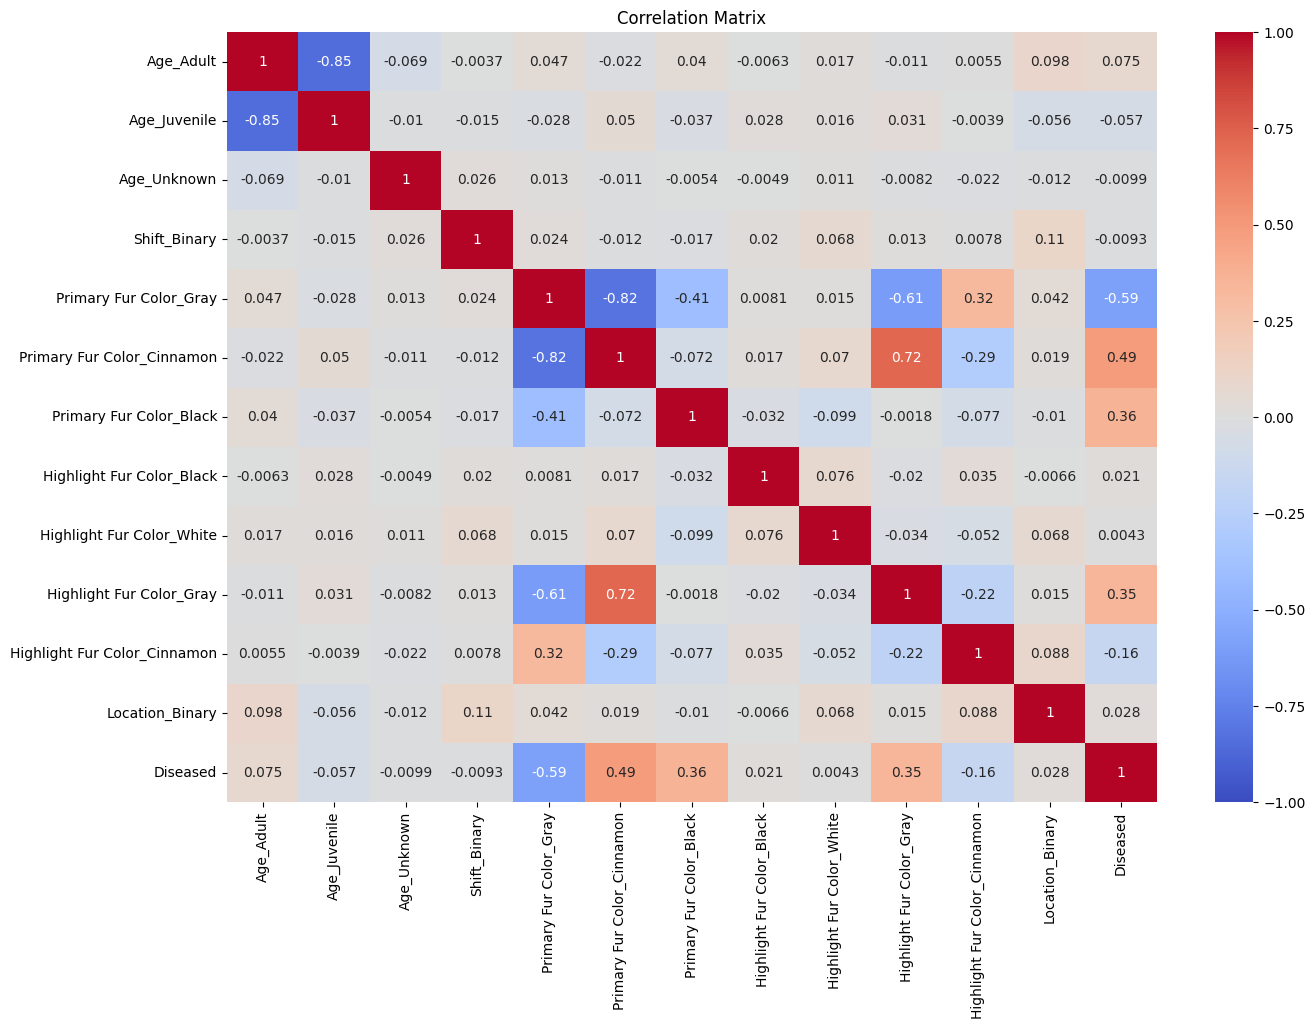

In [68]:
# heatmap of correlation matrix for Age_Adult	Age_Juvenile	Age_Unknown	Shift_Binary	Primary Fur Color_Gray	Primary Fur Color_Cinnamon	Primary Fur Color_Black	Highlight Fur Color_Black	Highlight Fur Color_White	Highlight Fur Color_Gray	Highlight Fur Color_Cinnamon	Location_Binary, Diseased

plt.figure(figsize=(15, 10))

sns.heatmap(train[['Age_Adult', 'Age_Juvenile', 'Age_Unknown', 'Shift_Binary', 'Primary Fur Color_Gray', 'Primary Fur Color_Cinnamon', 'Primary Fur Color_Black', 'Highlight Fur Color_Black', 'Highlight Fur Color_White', 'Highlight Fur Color_Gray', 'Highlight Fur Color_Cinnamon', 'Location_Binary', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()


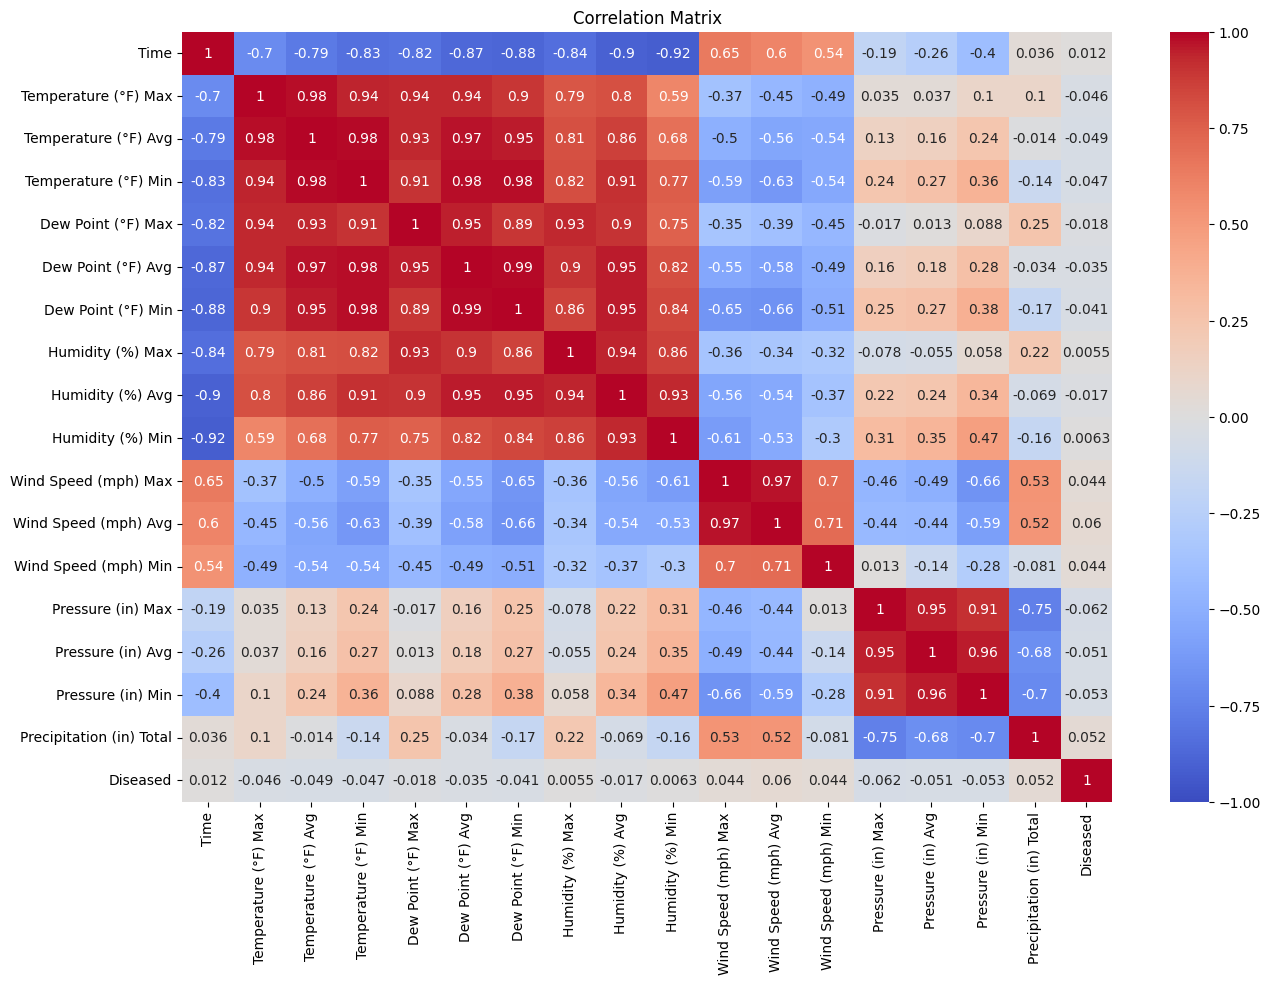

In [70]:
# heatmap of Time	Temperature (°F) Max	Temperature (°F) Avg	Temperature (°F) Min	Dew Point (°F) Max	Dew Point (°F) Avg	Dew Point (°F) Min	Humidity (%) Max	Humidity (%) Avg	Humidity (%) Min	Wind Speed (mph) Max	Wind Speed (mph) Avg	Wind Speed (mph) Min	Pressure (in) Max	Pressure (in) Avg	Pressure (in) Min	Precipitation (in) Total

plt.figure(figsize=(15, 10))

sns.heatmap(train[['Time', 'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min', 'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 'Precipitation (in) Total', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()


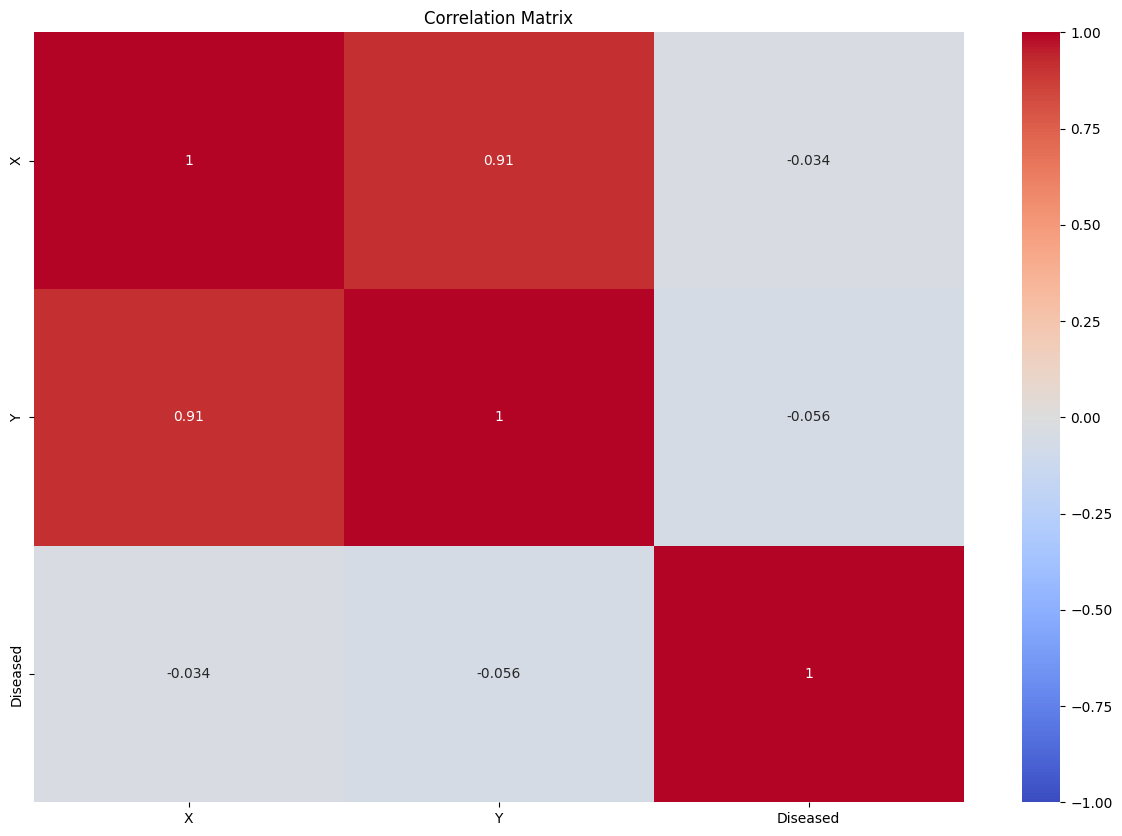

In [74]:
# heatmap of X	Y

plt.figure(figsize=(15, 10))

sns.heatmap(train[['X', 'Y', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

In [75]:
# get the day from the date

train['Day'] = train['Date'].dt.day


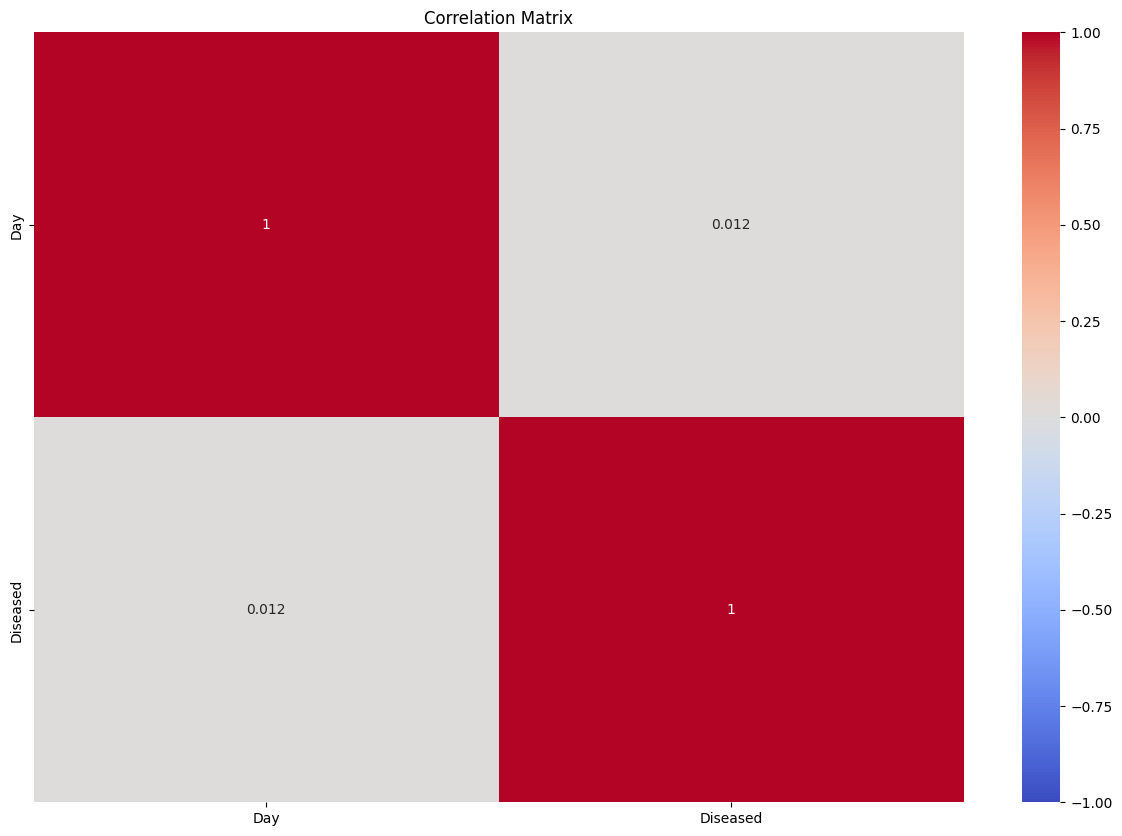

In [77]:
# heatmap of Day

plt.figure(figsize=(15, 10))

sns.heatmap(train[['Day', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

<Axes: xlabel='Day', ylabel='Diseased'>

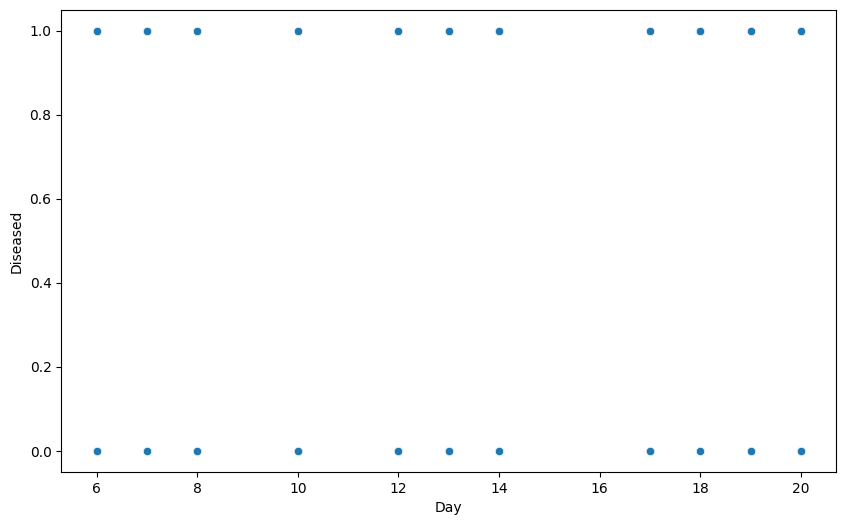

In [80]:

# scatterplot of day and Diseased

plt.figure(figsize=(10, 6))

sns.scatterplot(data=train, x='Day', y='Diseased')

In [81]:
# break up first half of month and second half of month

train['First_Half'] = train['Day'].apply(lambda x: 1 if x <= 15 else 0)

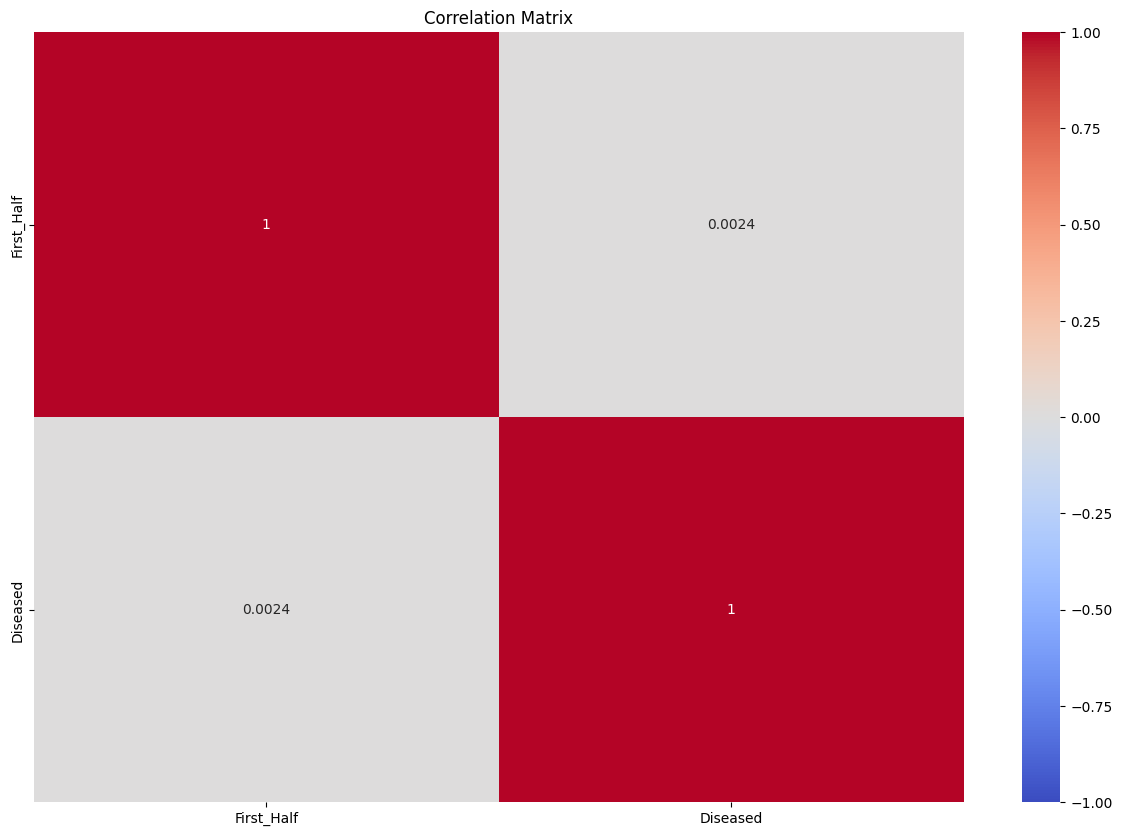

In [82]:
# heatmap of First_Half

plt.figure(figsize=(15, 10))

sns.heatmap(train[['First_Half', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Hectare Squirrel Number'}>,
        <Axes: title={'center': 'Running'}>,
        <Axes: title={'center': 'Chasing'}>,
        <Axes: title={'center': 'Climbing'}>],
       [<Axes: title={'center': 'Eating'}>,
        <Axes: title={'center': 'Foraging'}>,
        <Axes: title={'center': 'Kuks'}>,
        <Axes: title={'center': 'Quaas'}>,
        <Axes: title={'center': 'Moans'}>,
        <Axes: title={'center': 'Tail flags'}>,
        <Axes: title={'center': 'Tail twitches'}>],
       [<Axes: title={'center': 'Approaches'}>,
        <Axes: title={'center': 'Indifferent'}>,
        <Axes: title={'center': 'Runs from'}>,
        <Axes: title={'center': 'Time'}>,
        <Axes: title={'center': 'Temperature (°F) Max'}>,
        <Axes: title={'center': 'Temperature (°F) Avg'}>,
        <Axes: title={'center': 'Temperature (°F) Min'}>],
       [<Ax

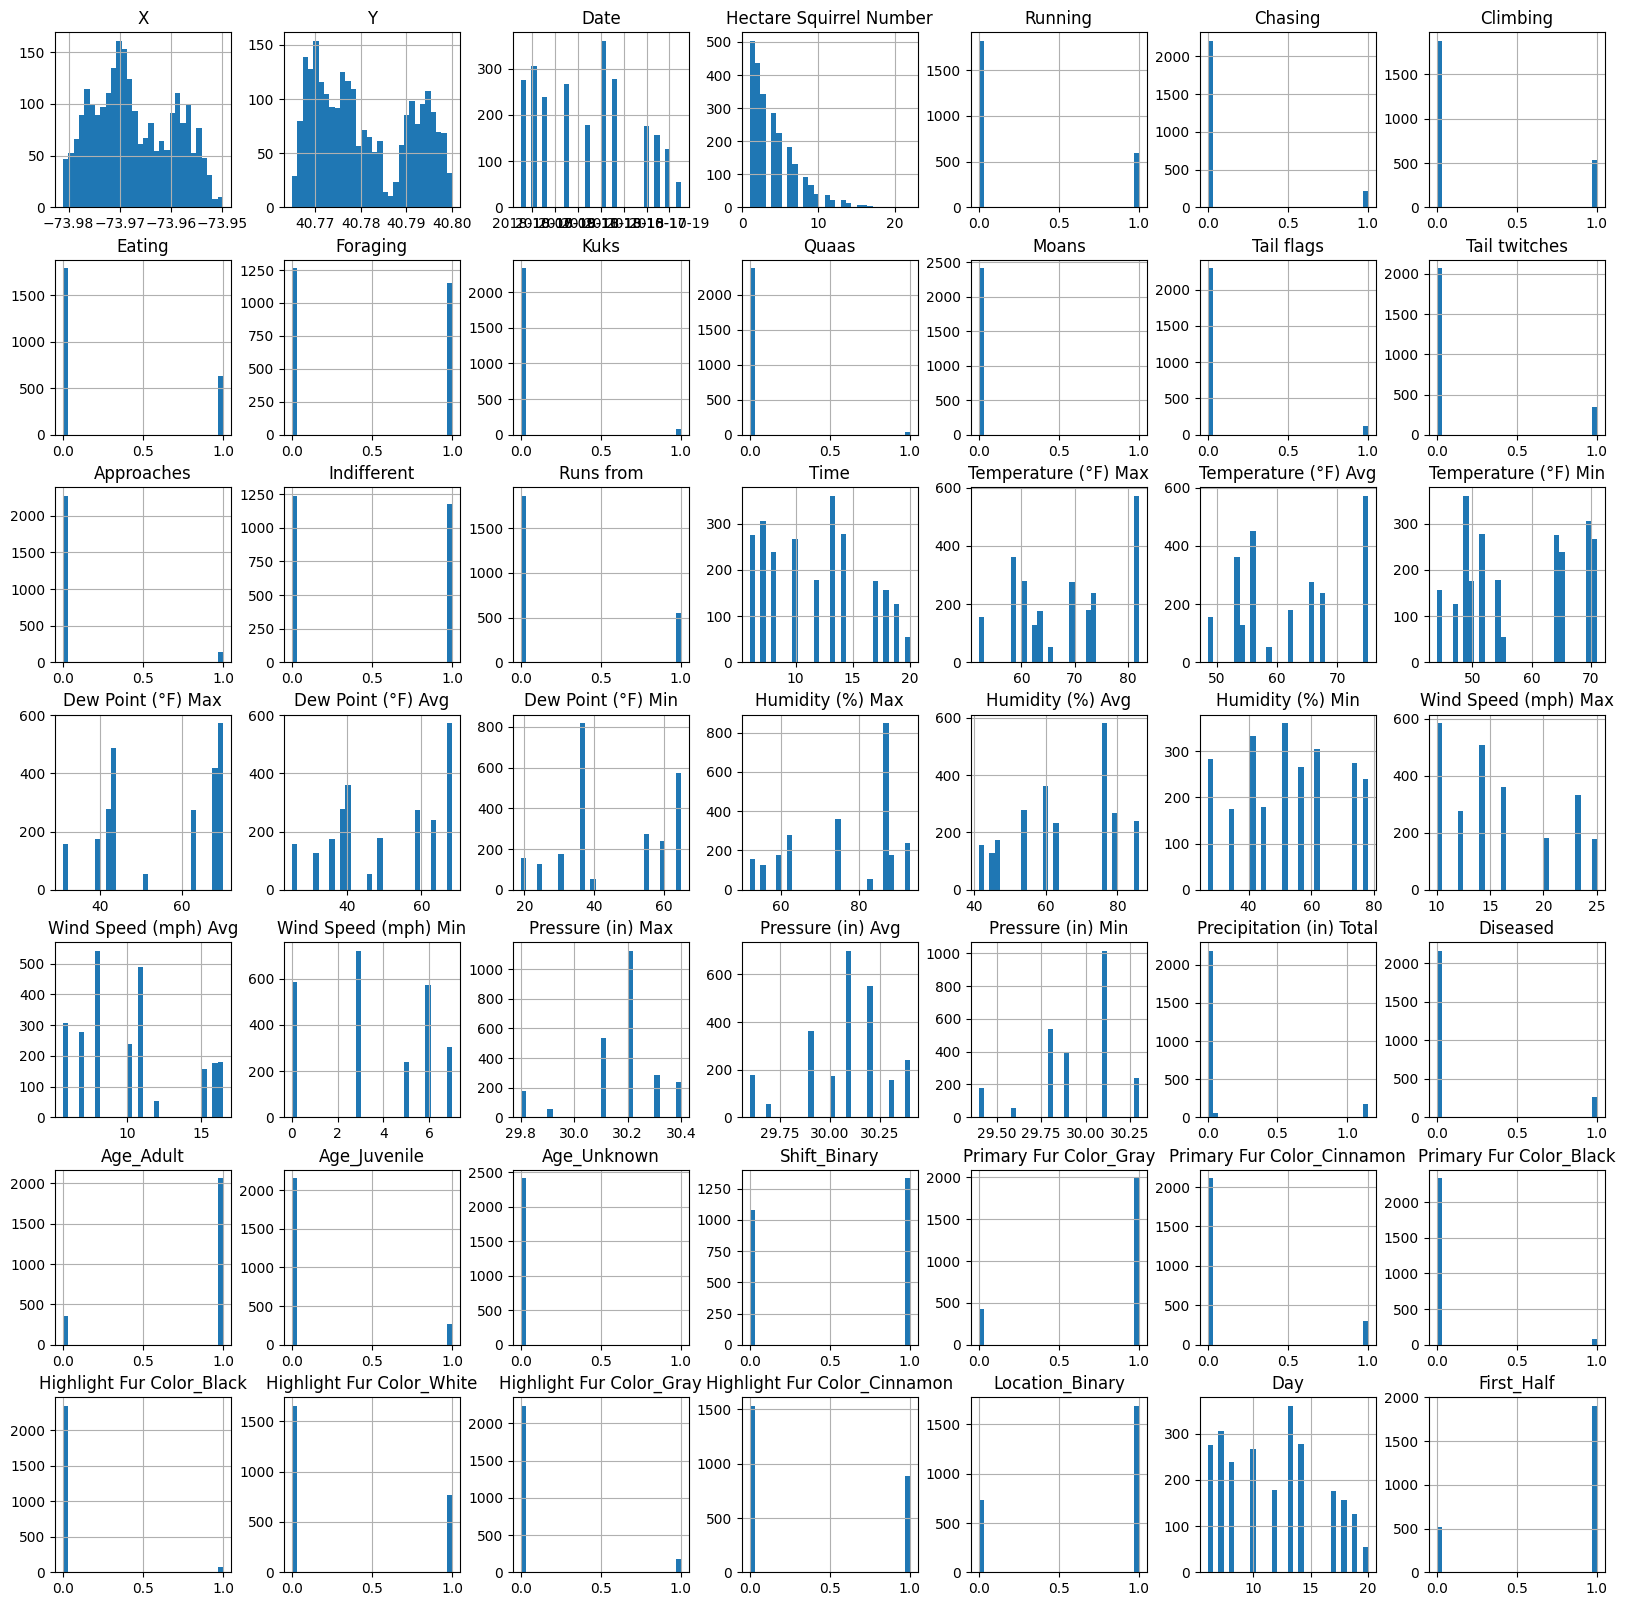

In [83]:
#histogram of train

train.hist(figsize=(20, 20), bins=30)